1. 주요변수 설명 
- 각 변수별 분포(hist) 확인

2. 평가지표 선택(recall vs precision) 및 평가지표 성능개선
- 계약할 것이라고 예측된 고객에게 아웃바운드 콜을 보냈으나 계약에 성공하지 않았을 때의 loss vs 계약하지 않을 것이라고 예측되었으나 실제로는 계약할 고객에게 아웃바운드 콜을 보내지 않았을 때의 loss
- 보험은 성사되었을 때의 이윤이 아주 크기 때문에, 후자의 loss가 더 클 것으로 예상
- 따라서 recall을 최대화시키는 것이 보험사 입장에서 더 적절
- threshold 조정에 따른 recall 값 확인 필요

3. 변수 선택
- pca, kernel-pca 의 variance_ratio
- selectkbest의 k selection
- xgboosting.feature_importances

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest,f_classif 
from sklearn.model_selection import train_test_split  

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## **1. 전처리 및 시각화**

<설명해야할 데이터 Column>

- Id : 범주형. Drop
- Age : 연속형. 범주화 후 범주화 Drop. 스케일링
- Job : 범주형. 원핫인코딩
- Marital : 범주형. 원핫인코딩
- Education : 범주형. 원핫인코딩
- Default : 범주형
- Balance : 연속형. 스케일링
- HHInsurance : 범주형
- Carloan : 범주형
- Communication : 범주형. 원핫인코딩
- LastContactDay : 연속형. 범주화 후 범주화 Drop. 스케일링
- LastContactMonth : 범주형. 원핫인코딩
- NoOfContacts : 연속형. 범주화 후 범주형 Drop. 스케일링
- DaysPassed : 연속형. DayPass 구한 뒤(범주화) 연속형 Drop. 
- PrevAttempts : 연속형. Prevatt 구한 뒤(범주화) 연속형 Drop.
- Outcome : 결측치 과다로 Drop
- CallStart : 연속형(시간)
- CallEnd : 연속형(시간)
=> CallDuration(연속형) 구한 뒤 Drop. 스케일링


In [ ]:
data=pd.read_csv('/content/carInsurance_train.csv')

In [ ]:
data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

Job, Education, Communication에 대헤 결측치 대체할 방법 필요.

Outcome은 결측치가 75% 이상이므로 제거한다.

In [ ]:
data.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


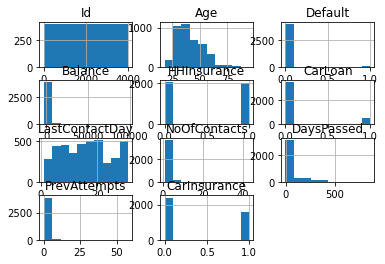

In [ ]:
data.hist()
plt.show()

연속형 변수의 경우 정규분포를 가진 변수가 Age를 제외하고는 거의 없다. 스케일링 시에 이를 참고하여 MinMax 사용.

Balance, NoOfContacts, DaysPassed, PrevAttempts와 같이 특정 구간에 데이터 수가 몰려있는 변수는 시각화 결과에 따라 범주화하는 것이 나은지 여부를 판단할 것이다.

In [ ]:
# 결측치 확인 결과 결측치 비율이 지나치게 높은 Outcome 변수는 삭제하고
# Job, Education, Communication은 최빈값을 imputation하기로 결정
print("Missing values (Counts):")
print("\n")
print(data.isnull().sum())
print("\n")
print("Missing values (Percentage (%)):")
print("\n")
print((data.isnull().sum()/len(data))*100)

Missing values (Counts):


Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64


Missing values (Percentage (%)):


Id                   0.000
Age                  0.000
Job                  0.475
Marital              0.000
Education            4.225
Default              0.000
Balance              0.000
HHInsurance          0.000
CarLoan              0.000
Communication       22.550
LastContactDay       0.000
LastContactMonth     0.000
NoOfContacts         0.000
DaysPassed           0.000
PrevAttempts         0.000
Outcome             76.050
CallStart       

In [ ]:
print("Job Field")
print(data.Job.value_counts())
print("\n")
print("Education Field")
print(data.Education.value_counts())
print("\n")
print("Communication Field")
print(data.Communication.value_counts())

Job Field
management       893
blue-collar      759
technician       660
admin.           459
services         330
retired          249
self-employed    140
student          131
unemployed       130
entrepreneur     121
housemaid        109
Name: Job, dtype: int64


Education Field
secondary    1988
tertiary     1282
primary       561
Name: Education, dtype: int64


Communication Field
cellular     2831
telephone     267
Name: Communication, dtype: int64


In [ ]:
# 최빈값 확인
print("Job Field")
print(data.Job.mode())
print("\n")
print("Education Field")
print(data.Education.mode())
print("\n")
print("Communication Field")
print(data.Communication.mode())

Job Field
0    management
dtype: object


Education Field
0    secondary
dtype: object


Communication Field
0    cellular
dtype: object


결측치에 대해서 각 변수들의 최빈값으로 대체하였다.

In [ ]:
# 최빈값(mode) imputation
for i in ["Job","Education","Communication"]:
    data[i]=data[i].fillna(data[i].mode()[0])

In [ ]:
data.drop('Outcome',axis=1,inplace=True)

In [ ]:
data[['CallStart','CallEnd']]=data[['CallStart','CallEnd']].astype('datetime64[ns]')

In [ ]:
data['Call_Duration']=data['CallEnd']-data['CallStart']
data['Call_Duration']=data['Call_Duration'].dt.components['minutes']*60 + data['Call_Duration'].dt.components['seconds']
data['Call_Duration'].head()

0     70
1    185
2    340
3    819
4    192
Name: Call_Duration, dtype: int64

전화를 언제 시작해서 언제 끊었는지보다 통화 지속시간이 더 중요한 변수라고 판단, CallDuration 변수를 추가하였다. 단위는 '초'.

In [ ]:
data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance,Call_Duration
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,2021-02-21 13:45:20,2021-02-21 13:46:30,0,70
1,2,32,blue-collar,married,primary,0,1156,1,0,cellular,26,may,5,-1,0,2021-02-21 14:49:03,2021-02-21 14:52:08,0,185
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,2021-02-21 16:30:24,2021-02-21 16:36:04,1,340
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,2021-02-21 12:06:43,2021-02-21 12:20:22,1,819
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,2021-02-21 14:35:44,2021-02-21 14:38:56,0,192


Age를 연령대별로 나누어 각 구간별 종속변수와의 관계를 나타내었다.

- 대부분이 30대, 40대에 속한다.
- 30대, 40대에서 신청률이 제일 낮았고, 반대로 고령층과 사회 초년생의 신청률이 높았다.

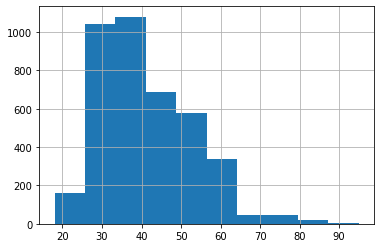

In [ ]:
data['Age'].hist()

In [ ]:
Ag_crosstab=pd.crosstab(index=data['Age'],columns=data['CarInsurance'])
Ag_crosstab['Percentage Enrolled']=round(Ag_crosstab[1]/(Ag_crosstab[0]+Ag_crosstab[1])*100,2)

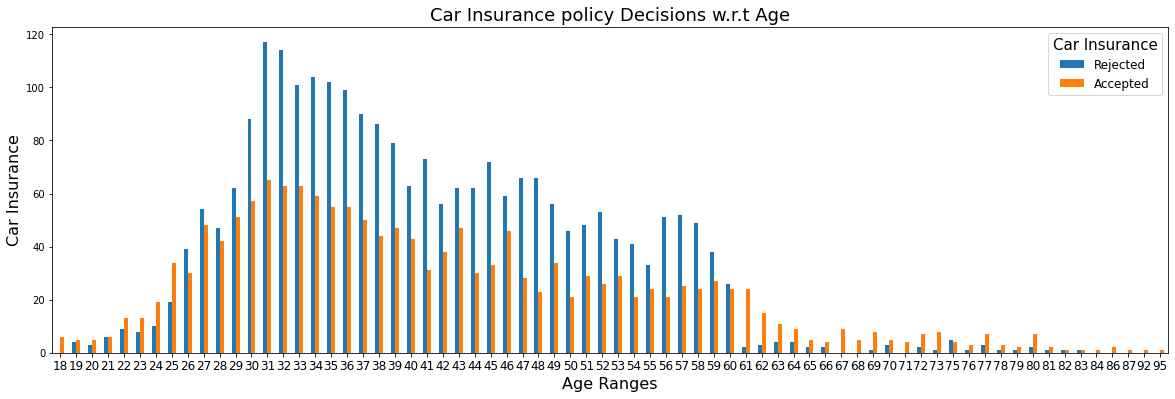

In [ ]:
Ag_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Age Ranges',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance policy Decisions w.r.t Age',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
def agerange(age):
    if age >= 18 and age <= 20:
        return "18-20"
    elif age >= 21 and age <= 30:
        return "21-30"
    elif age >= 31 and age <= 40:
        return "31-40"
    elif age >= 41 and age <= 50:
        return "41-50"
    elif age >= 51 and age <= 60:
        return "51-60"
    elif age >= 61 and age <= 70:
        return "61-70"
    elif age >= 71 and age <= 80:
        return "71-80"
    elif age >=81:
        return "Above 80"

In [ ]:
data['Age Range']=data['Age'].apply(agerange)

In [ ]:
Age_crosstab=pd.crosstab(index=data['Age Range'],columns=data['CarInsurance'])
Age_crosstab['Percentage Enrolled']=round(Age_crosstab[1]/(Age_crosstab[0]+Age_crosstab[1])*100,2)
Age_crosstab

CarInsurance,0,1,Percentage Enrolled
Age Range,,,
18-20,7,16,69.57
21-30,342,313,47.79
31-40,955,544,36.29
41-50,618,331,34.88
51-60,434,250,36.55
61-70,21,95,81.90
71-80,16,45,73.77
Above 80,3,10,76.92


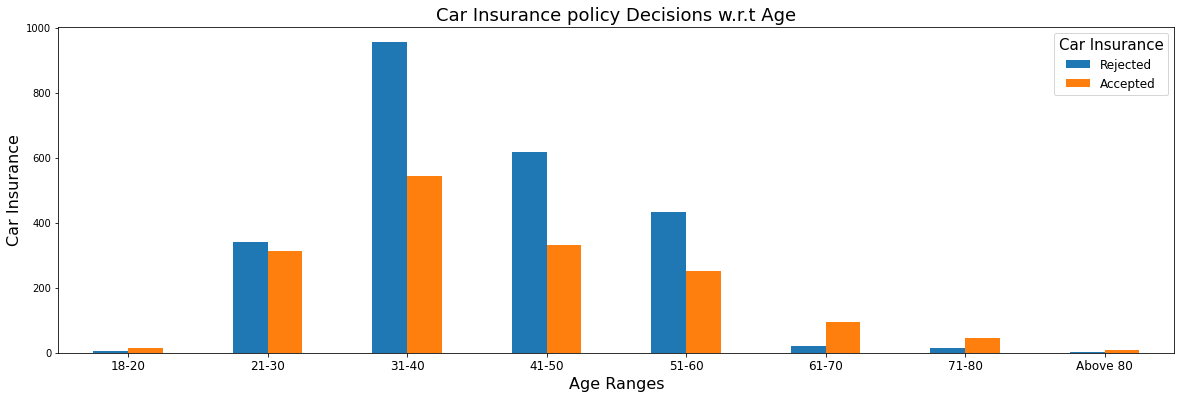

In [ ]:
Age_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Age Ranges',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance policy Decisions w.r.t Age',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- Blue-collar와 Management가 가장 많다.
- 학생, 은퇴자, 비근로자들의 가입률이 높았다.

(Marital, Education, Communication은 동일한 방식으로 해석. 범주별로 가입률 차이가 없을 수도 있다.)

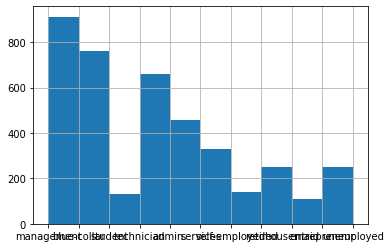

In [ ]:
data['Job'].hist()
plt.show()

In [ ]:
Job_crosstab=pd.crosstab(data['Job'],data['CarInsurance'],colnames=['Car Insurance'])
Job_crosstab['Percentage Enrolled']=round(Job_crosstab[1]/(Job_crosstab[0]+Job_crosstab[1])*100,2)
Job_crosstab

Car Insurance,0,1,Percentage Enrolled
Job,,,
admin.,274,185,40.31
blue-collar,540,219,28.85
entrepreneur,86,35,28.93
housemaid,72,37,33.94
management,511,401,43.97
retired,103,146,58.63
self-employed,86,54,38.57
services,218,112,33.94
student,44,87,66.41


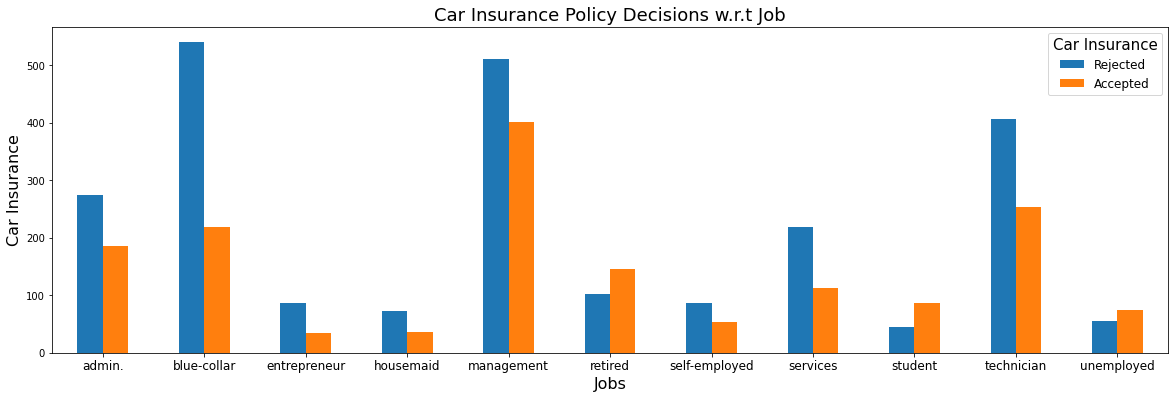

In [ ]:
Job_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Jobs',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Job',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

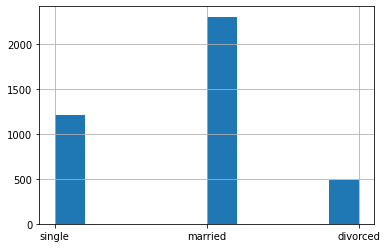

In [ ]:
data['Marital'].hist()
plt.show()

In [ ]:
Marital_crosstab=pd.crosstab(data['Marital'],data['CarInsurance'],colnames=['Car Insurance'])
Marital_crosstab['Percentage Enrolled']=round(Marital_crosstab[1]/(Marital_crosstab[0]+Marital_crosstab[1])*100,2)
Marital_crosstab

Car Insurance,0,1,Percentage Enrolled
Marital,,,
divorced,273,210,43.48
married,1471,833,36.15
single,652,561,46.25


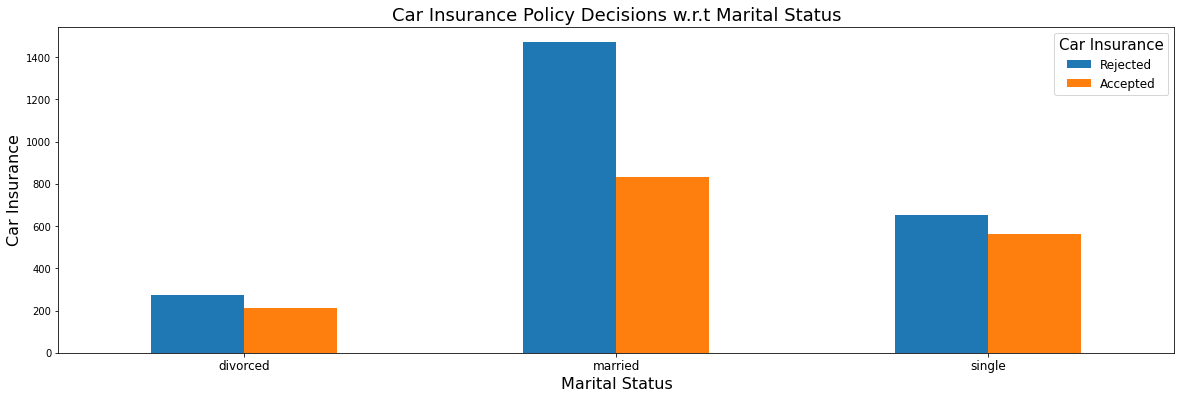

In [ ]:
Marital_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Marital Status',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Marital Status',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

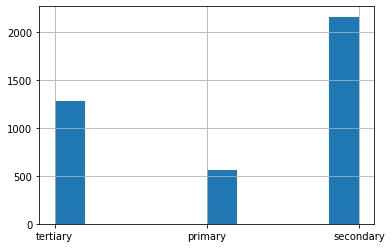

In [ ]:
data['Education'].hist()
plt.show()

In [ ]:
Education_crosstab=pd.crosstab(data['Education'],data['CarInsurance'],colnames=['Car Insurance'])
Education_crosstab['Percentage Enrolled']=round(Education_crosstab[1]/(Education_crosstab[0]+Education_crosstab[1])*100,2)
Education_crosstab

Car Insurance,0,1,Percentage Enrolled
Education,,,
primary,366,195,34.76
secondary,1348,809,37.51
tertiary,682,600,46.80


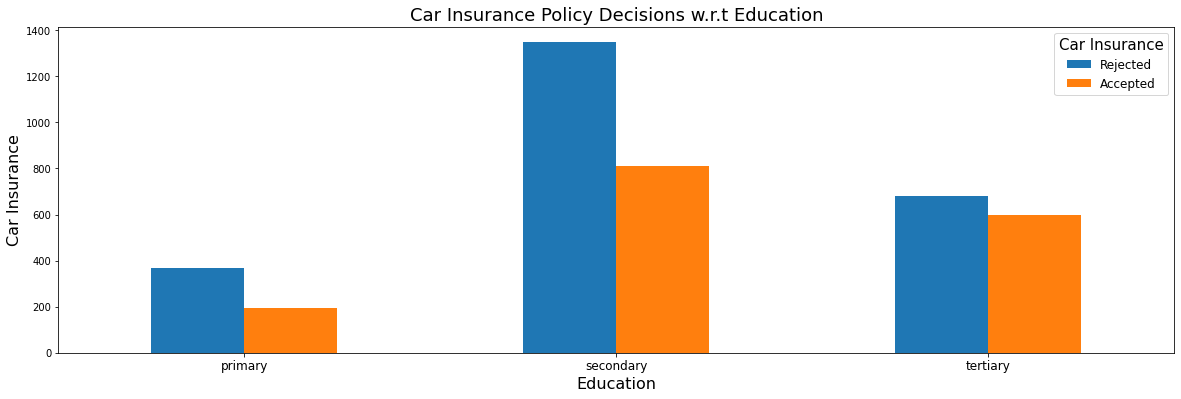

In [ ]:
Education_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Education',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Education',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- HHInsurance, Default, Carloan 역시 범주별로 차이가 크게 나타나지 않는다. 

In [ ]:
HHInsurance_crosstab=pd.crosstab(data['HHInsurance'],data['CarInsurance'],colnames=['Car Insurance'])
HHInsurance_crosstab['Percentage Enrolled']=round(HHInsurance_crosstab[1]/(HHInsurance_crosstab[0]+HHInsurance_crosstab[1])*100,2)
HHInsurance_crosstab

Car Insurance,0,1,Percentage Enrolled
HHInsurance,,,
0,1016,1013,49.93
1,1380,591,29.98


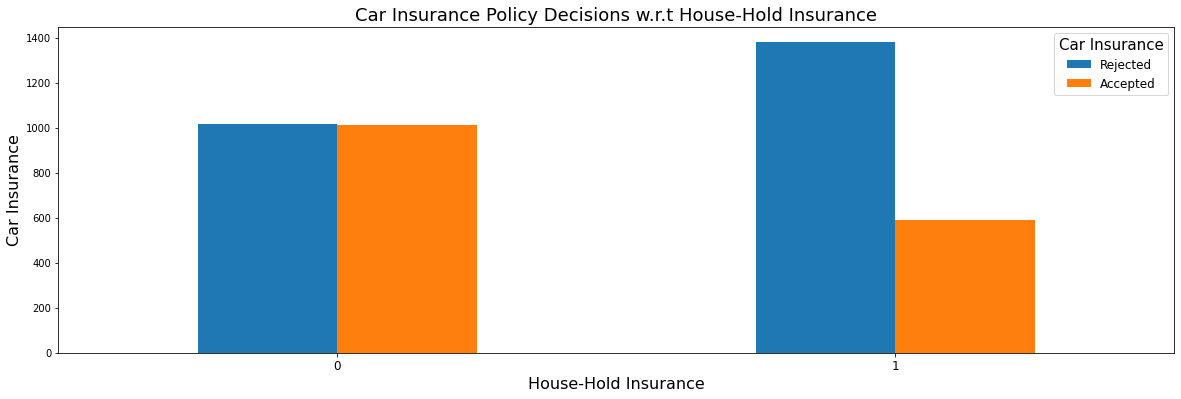

In [ ]:
HHInsurance_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('House-Hold Insurance',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t House-Hold Insurance',fontsize=18)
plt.legend(['Rejected','Accepted','Percentage Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
Default_crosstab=pd.crosstab(data['Default'],data['CarInsurance'],colnames=['Car Insurance'])
Default_crosstab['Percentage Enrolled']=round(Default_crosstab[1]/(Default_crosstab[0]+Default_crosstab[1])*100,2)
Default_crosstab

Car Insurance,0,1,Percentage Enrolled
Default,,,
0,2352,1590,40.33
1,44,14,24.14


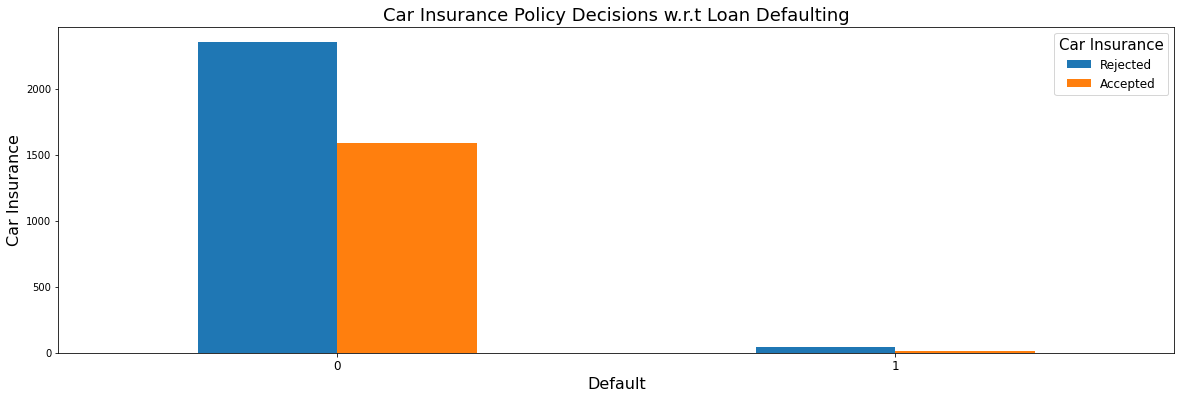

In [ ]:
Default_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Default',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Loan Defaulting',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
CarLoan_crosstab=pd.crosstab(data['CarLoan'],data['CarInsurance'],colnames=['Car Insurance'])
CarLoan_crosstab['Percentage Enrolled']=round(CarLoan_crosstab[1]/(CarLoan_crosstab[0]+CarLoan_crosstab[1])*100,2)
CarLoan_crosstab

Car Insurance,0,1,Percentage Enrolled
CarLoan,,,
0,2016,1452,41.87
1,380,152,28.57


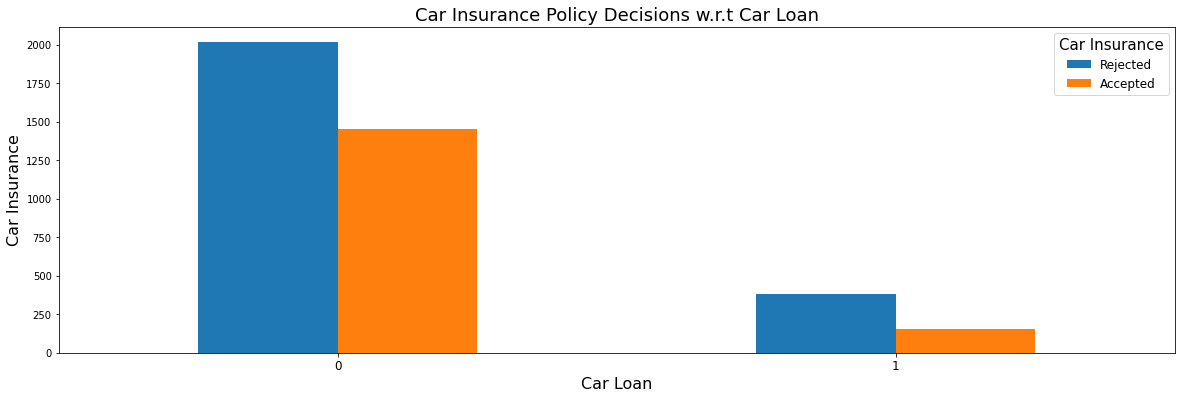

In [ ]:
CarLoan_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Car Loan',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Car Loan',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
Communication_crosstab=pd.crosstab(data['Communication'],data['CarInsurance'],colnames=['Car Insurance'])
Communication_crosstab['Percentage Enrolled']=round(Communication_crosstab[1]/(Communication_crosstab[0]+Communication_crosstab[1])*100,2)
Communication_crosstab

Car Insurance,0,1,Percentage Enrolled
Communication,,,
cellular,2252,1481,39.67
telephone,144,123,46.07


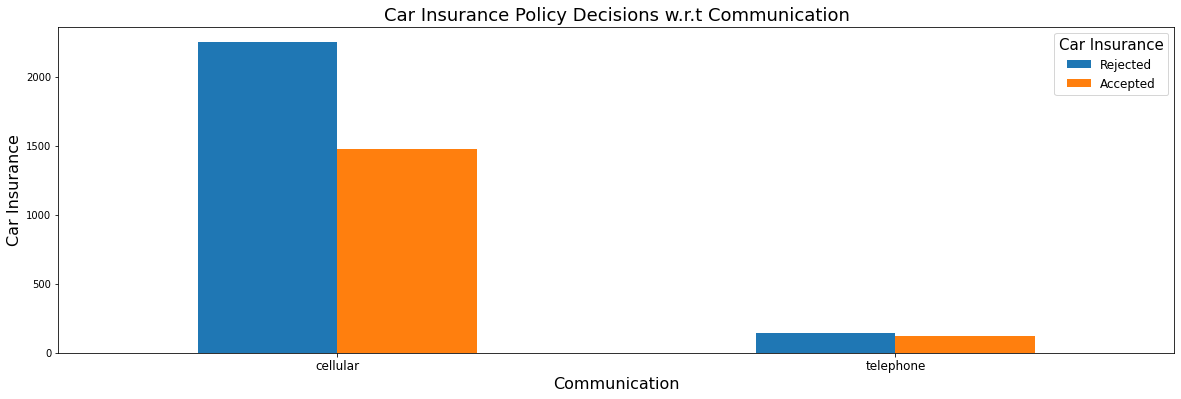

In [ ]:
Communication_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Communication',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Communication',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- 각 month 별로 데이터 수도 불균형적으로 분포되어 있고, 범주별 가입률의 차이도 제각각이다.
- 3월, 9월, 10월, 12월에 가입률이 매우 높지만, 해당 범주의 데이터 수가 적다.
- 2월, 4월의 경우 데이터 수와 가입률 모두 높은 편이다.

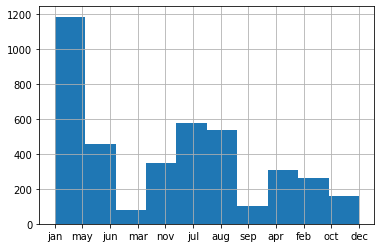

In [ ]:
data['LastContactMonth'].hist()
plt.show()

In [ ]:
LastContactMonth_crosstab=pd.crosstab(data['LastContactMonth'],data['CarInsurance'],colnames=['Car Insurance'])
LastContactMonth_crosstab['Percentage Enrolled']=round(LastContactMonth_crosstab[1]/(LastContactMonth_crosstab[0]+
                                                                                     LastContactMonth_crosstab[1])*100,2)
LastContactMonth_crosstab

Car Insurance,0,1,Percentage Enrolled
LastContactMonth,,,
apr,150,156,50.98
aug,342,194,36.19
dec,7,34,82.93
feb,129,133,50.76
jan,86,48,35.82
jul,364,209,36.47
jun,283,171,37.67
mar,15,64,81.01
may,760,289,27.55


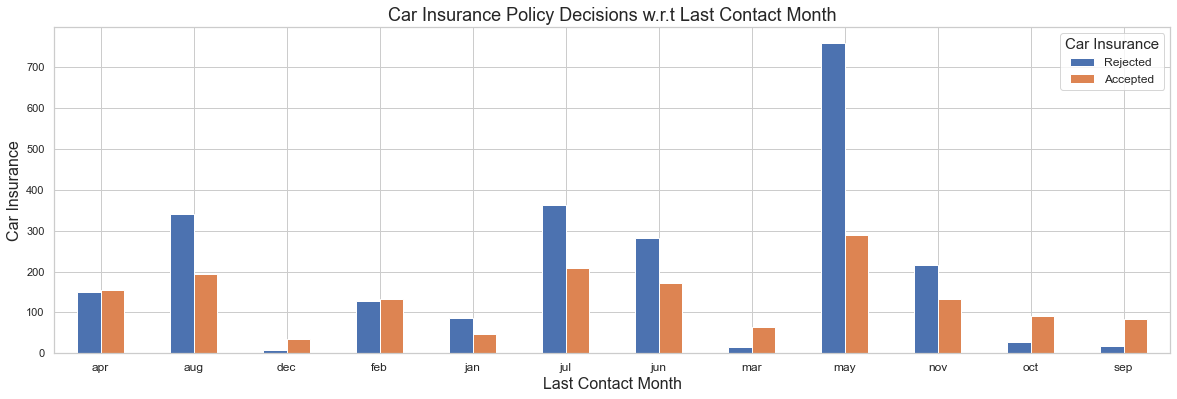

In [ ]:
LastContactMonth_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Last Contact Month',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Last Contact Month',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- Day의 분포가 비교적 골고루 되어 있고, Day 별 가입률의 차이가 크지 않다.
- 월초, 월중, 월말로 범주화하여도 가입률의 차이는 크게 나타나진 않는다.

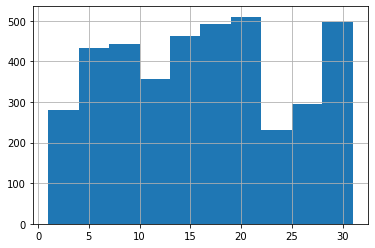

In [ ]:
data['LastContactDay'].hist()
plt.show()

In [ ]:
LastContactD_crosstab=pd.crosstab(data['LastContactDay'],data['CarInsurance'],colnames=['Car Insurance'])
LastContactD_crosstab['Percentage Enrolled']=round(LastContactD_crosstab[1]/(LastContactD_crosstab[0]+LastContactD_crosstab[1])*100,2)
LastContactD_crosstab

Car Insurance,0,1,Percentage Enrolled
LastContactDay,,,
1,16,33,67.35
2,79,59,42.75
3,45,48,51.61
4,65,71,52.21
5,91,61,40.13
6,94,51,35.17
7,95,62,39.49
8,102,56,35.44
9,83,46,35.66


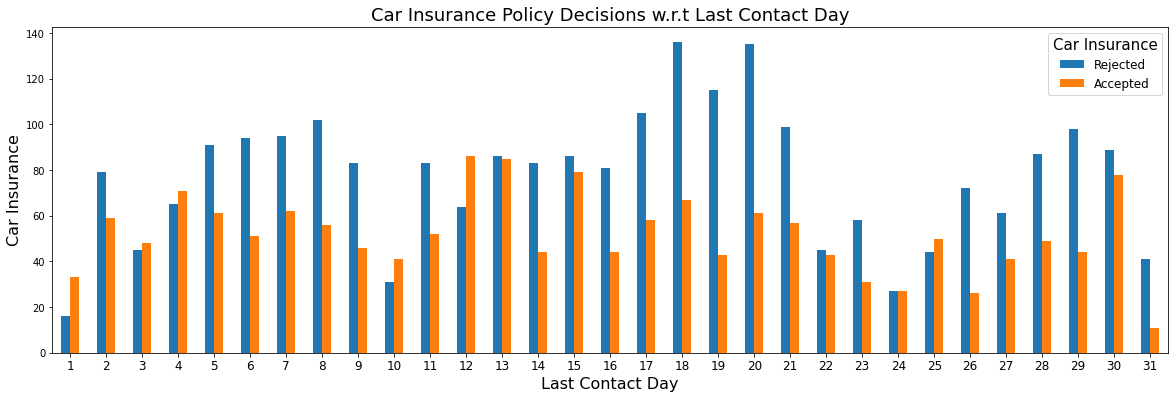

In [ ]:
LastContactD_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Last Contact Day',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Last Contact Day',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
def Day_Categories(day):
    if(day >= 1 and day < 11):
        return "Month Start"
    elif(day >= 11 and day < 21):
        return "Month Middle"
    elif(day >= 21 and day <= 31):
        return "Month End"

In [ ]:
data['Day_Categories']=data['LastContactDay'].apply(Day_Categories)

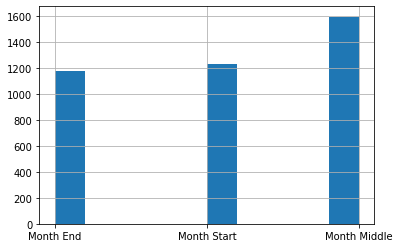

In [ ]:
data['Day_Categories'].hist()
plt.show()

In [ ]:
LastContactDay_crosstab=pd.crosstab(data['Day_Categories'],data['CarInsurance'],colnames=['Car Insurance'])
LastContactDay_crosstab['Percentage Enrolled']=round(LastContactDay_crosstab[1]/(LastContactDay_crosstab[0]+LastContactDay_crosstab[1])*100,2)
LastContactDay_crosstab

Car Insurance,0,1,Percentage Enrolled
Day_Categories,,,
Month End,721,457,38.79
Month Middle,974,619,38.86
Month Start,701,528,42.96


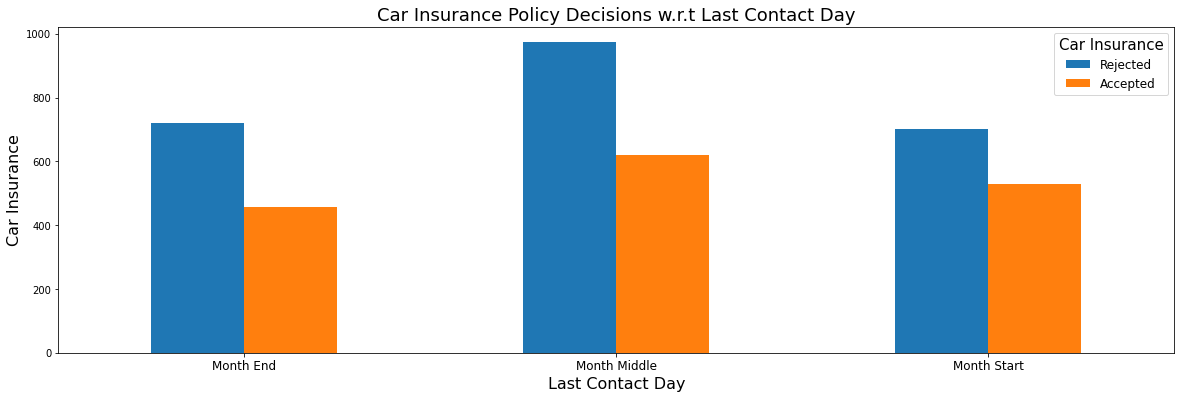

In [ ]:
LastContactDay_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Last Contact Day',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Last Contact Day',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- NoOfContact의 경우 대부분의 데이터가 10 이하의 값을 가지며, 값에 따라 가입률이 크게 변하지 않는다.
- 값이 지나치게 높은 데이터의 영향을 줄이기 위해 범주화를 실시하였다.

(0.0, 10.0, 0.0, 4000.0)

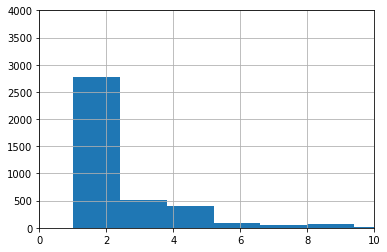

In [ ]:
data['NoOfContacts'].hist(bins=30)
plt.axis([0,10,0,4000])

In [ ]:
def num_contacts(contact):
    if(contact == 1):
        return "Contacted once"
    elif(contact > 1 and contact <= 10):
        return "Contacted More than once"
    elif(contact > 10):
        return "Contacted more than 10 times"

In [ ]:
data['NoOfContacts_Category']=data['NoOfContacts'].apply(num_contacts)

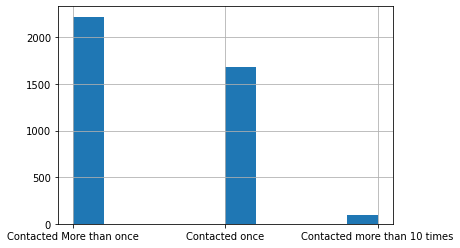

In [ ]:
data['NoOfContacts_Category'].hist()
plt.show()

In [ ]:
NoOfContacts_crosstab=pd.crosstab(data['NoOfContacts'],data['CarInsurance'],colnames=['Car Insurance'])
NoOfContacts_crosstab['Percentage Enrolled']=round(NoOfContacts_crosstab[1]/(NoOfContacts_crosstab[0]+NoOfContacts_crosstab[1])*100,2)
NoOfContacts_crosstab

Car Insurance,0,1,Percentage Enrolled
NoOfContacts,,,
1,912,773,45.88
2,671,414,38.16
3,311,205,39.73
4,156,81,34.18
5,114,52,31.33
6,62,26,29.55
7,34,15,30.61
8,27,14,34.15
9,18,2,10.00


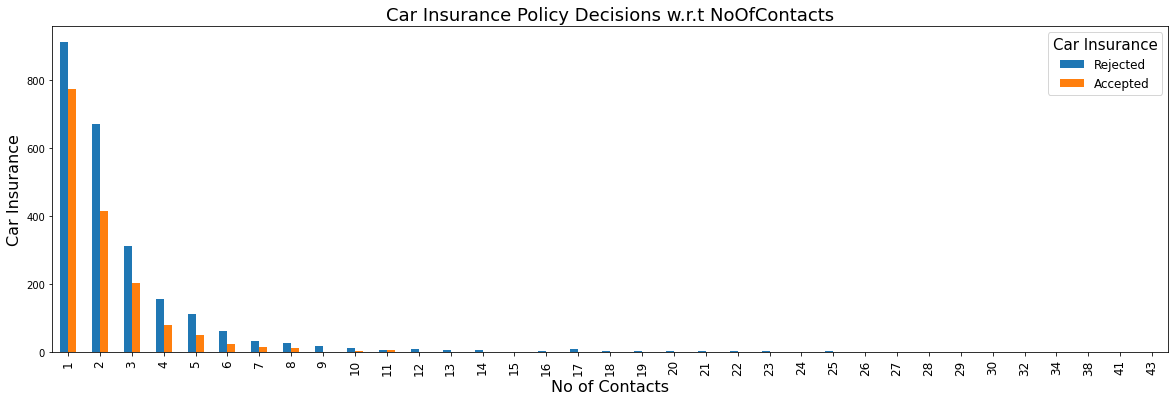

In [ ]:
NoOfContacts_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 90,fontsize=12)
plt.xlabel('No of Contacts',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t NoOfContacts',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

In [ ]:
NoOfContacts_Category_crosstab=pd.crosstab(data['NoOfContacts_Category'],data['CarInsurance'],colnames=['Car Insurance'])
NoOfContacts_Category_crosstab['Percentage Enrolled']=round(NoOfContacts_Category_crosstab[1]/(NoOfContacts_Category_crosstab[0]+
                                                                                     NoOfContacts_Category_crosstab[1])*100,2)
NoOfContacts_Category_crosstab

Car Insurance,0,1,Percentage Enrolled
NoOfContacts_Category,,,
Contacted More than once,1406,814,36.67
Contacted more than 10 times,78,17,17.89
Contacted once,912,773,45.88


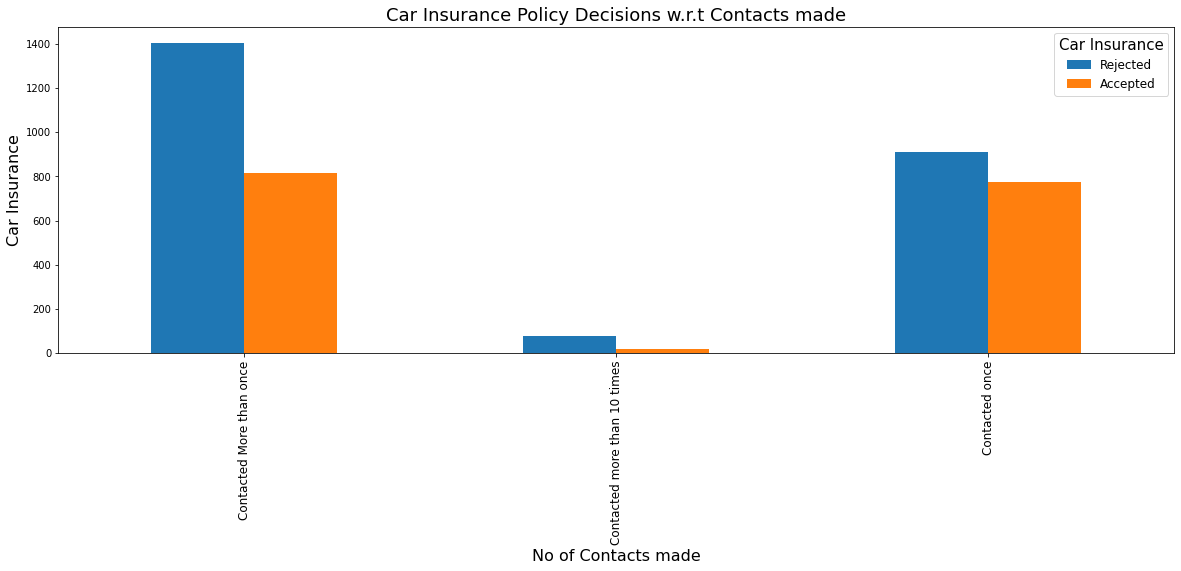

In [ ]:
NoOfContacts_Category_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 90,fontsize=12)
plt.xlabel('No of Contacts made',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Contacts made',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- Call Duration은 100~120분 대를 최빈값으로 갖는 right-skewed된 분포를 가진다.
- 전반적으로 시간이 길어질수록 가입률이 높아지는 경향을 보인다.

(0.0, 1000.0, 0.0, 400.0)

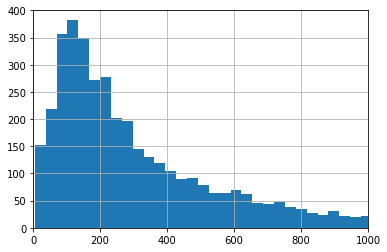

In [ ]:
data['Call_Duration'].hist(bins=100)
plt.axis([0,1000,0,400])

In [ ]:
Call_Duration_crosstab=pd.crosstab(data['Call_Duration'],data['CarInsurance'],colnames=['Car Insurance'],
                                   rownames=['Call Duration (in minutes)'])
Call_Duration_crosstab['Percentage Enrolled']=round(Call_Duration_crosstab[1]/(Call_Duration_crosstab[0]+ Call_Duration_crosstab[1])*100,2)
Call_Duration_crosstab

Car Insurance,0,1,Percentage Enrolled
Call Duration (in minutes),,,
5,8,0,0.0
6,2,0,0.0
7,6,0,0.0
8,4,0,0.0
9,9,0,0.0
...,...,...,...
2372,0,1,100.0
2456,0,1,100.0
2775,0,1,100.0


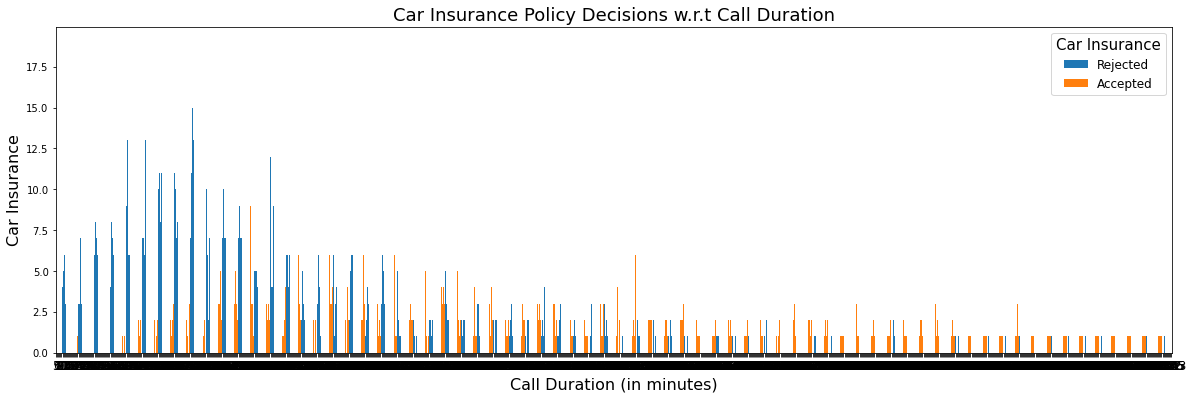

In [ ]:
Call_Duration_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('Call Duration (in minutes)',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t Call Duration',fontsize=18)
plt.legend(['Rejected','Accepted'],title='Car Insurance',title_fontsize=15,prop={"size":12})

- 대부분의 데이터가 특정 값(-1)을 가지거나 특정 값에 가까운 값을 가진다.
- 특정 값을 기준으로 범주화하였더니 범주별 가입률에 차이를 보였다.

(0.0, 25.0, 0.0, 3500.0)

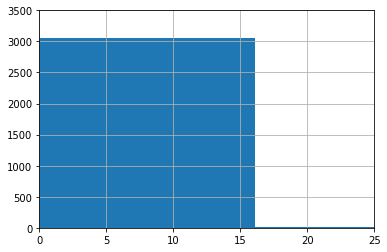

In [ ]:
data['DaysPassed'].hist(bins=50)
plt.axis([0,25,0,3500])

In [ ]:
daypass = []

for i in list(data['DaysPassed']):

  if i == -1 :
    daypass.append(0)

  else :
    daypass.append(1) 

In [ ]:
data['DayPass'] = daypass

In [ ]:
DayPass_crosstab=pd.crosstab(data['DayPass'],data['CarInsurance'],colnames=['Car Insurance'])
DayPass_crosstab['Percentage Enrolled']=round(DayPass_crosstab[1]/(DayPass_crosstab[0]+DayPass_crosstab[1])*100,2)
DayPass_crosstab

Car Insurance,0,1,Percentage Enrolled
DayPass,,,
0,1997,1045,34.35
1,399,559,58.35


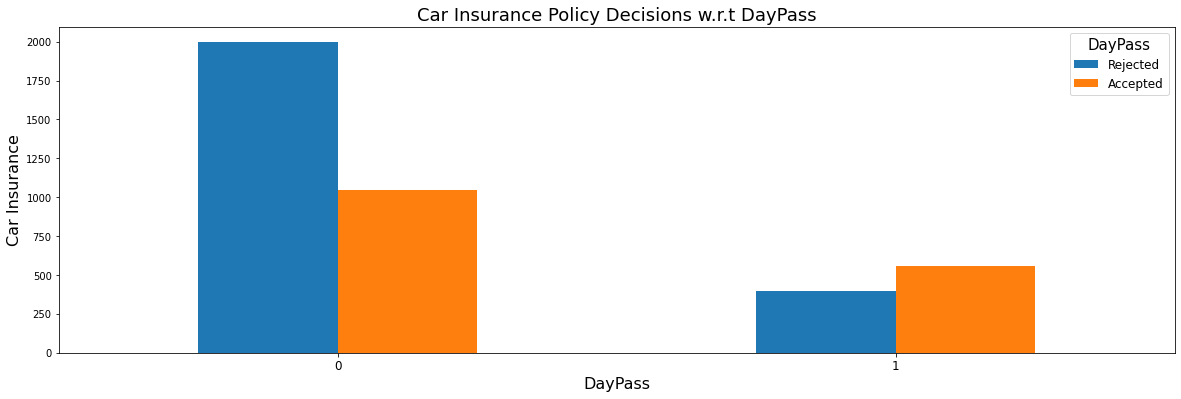

In [ ]:
DayPass_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('DayPass',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t DayPass',fontsize=18)
plt.legend(['Rejected','Accepted'],title='DayPass',title_fontsize=15,prop={"size":12})

- DaysPassed 해석과 동일.

In [ ]:
prevatt = []

for i in list(data['PrevAttempts']):

  if i == 0 :
    prevatt.append(0)

  else :
    prevatt.append(1) 

data['Prevatt'] = prevatt

In [ ]:
PrevAttempts_crosstab=pd.crosstab(data['PrevAttempts'],data['CarInsurance'],colnames=['Car Insurance'])
PrevAttempts_crosstab['Percentage Enrolled']=round(PrevAttempts_crosstab[1]/(PrevAttempts_crosstab[0]+PrevAttempts_crosstab[1])*100,2)
PrevAttempts_crosstab

Car Insurance,0,1,Percentage Enrolled
PrevAttempts,,,
0,1997,1045,34.35
1,149,186,55.52
2,109,142,56.57
3,47,78,62.40
4,33,46,58.23
5,26,34,56.67
6,9,16,64.00
7,6,15,71.43
8,4,14,77.78


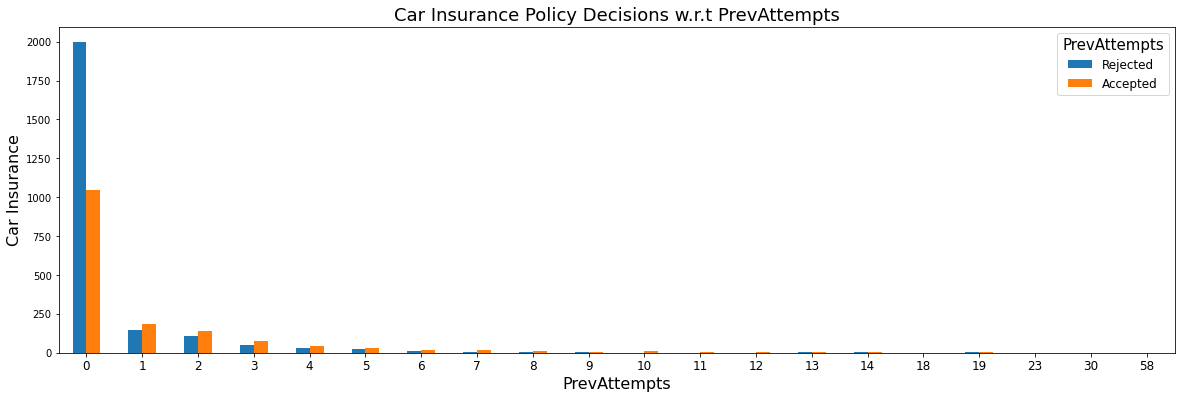

In [ ]:
PrevAttempts_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('PrevAttempts',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t PrevAttempts',fontsize=18)
plt.legend(['Rejected','Accepted'],title='PrevAttempts',title_fontsize=15,prop={"size":12})

In [ ]:
PrevAtt_crosstab=pd.crosstab(data['Prevatt'],data['CarInsurance'],colnames=['Car Insurance'])
PrevAtt_crosstab['Percentage Enrolled']=round(PrevAtt_crosstab[1]/(PrevAtt_crosstab[0]+PrevAtt_crosstab[1])*100,2)

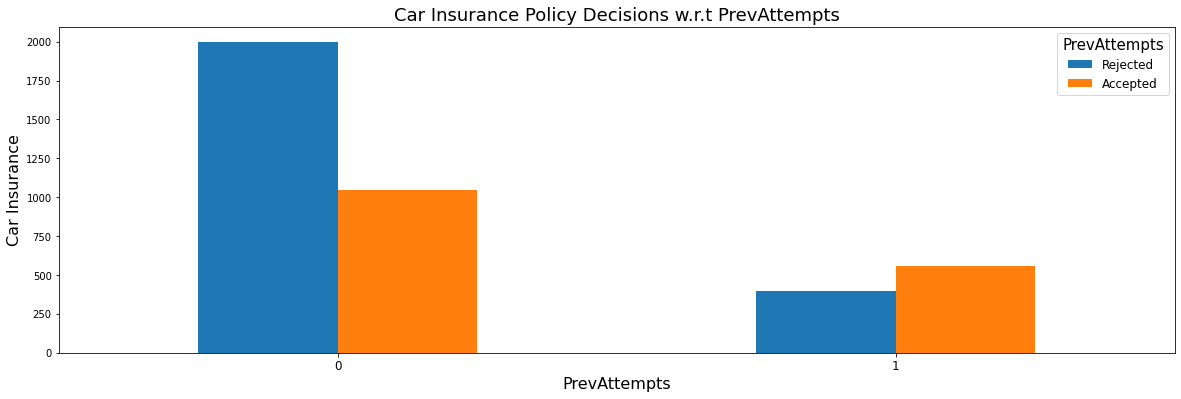

In [ ]:
PrevAtt_crosstab.drop(['Percentage Enrolled'], axis=1).plot(kind='bar',stacked=False,figsize=(20,6))
plt.xticks(rotation = 0,fontsize=12)
plt.xlabel('PrevAttempts',fontsize=16)
plt.ylabel('Car Insurance',fontsize=16)
plt.title('Car Insurance Policy Decisions w.r.t PrevAttempts',fontsize=18)
plt.legend(['Rejected','Accepted'],title='PrevAttempts',title_fontsize=15,prop={"size":12})

- Balance는 연속형 변수로 0값을 중심으로 약간 right-skewed 된 분포의 모습을 보인다.

(-5000.0, 10000.0, 0.0, 4000.0)

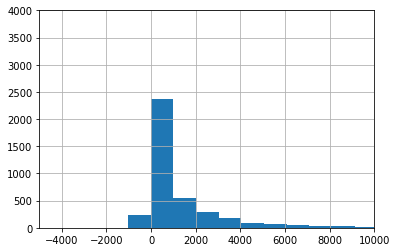

In [ ]:
data['Balance'].hist(bins=100)
plt.axis([-5000,10000,0,4000])

In [ ]:
Balance_crosstab=pd.crosstab(data['Balance'],data['CarInsurance'],colnames=['Car Insurance'])
Balance_crosstab['Percentage Enrolled']=round(Balance_crosstab[1]/(Balance_crosstab[0]+Balance_crosstab[1])*100,2)
Balance_crosstab

Car Insurance,0,1,Percentage Enrolled
Balance,,,
-3058,0,1,100.0
-1730,1,0,0.0
-1317,1,0,0.0
-1246,1,0,0.0
-1206,0,1,100.0
...,...,...,...
38279,1,0,0.0
43074,1,0,0.0
45248,0,1,100.0


In [ ]:
data.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance,Call_Duration,Age Range,Day_Categories,NoOfContacts_Category,DayPass,Prevatt
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,2021-02-22 13:45:20,2021-02-22 13:46:30,0,70,31-40,Month Ending,Contacted More than once,0,0
1,2,32,blue-collar,married,primary,0,1156,1,0,cellular,26,may,5,-1,0,2021-02-22 14:49:03,2021-02-22 14:52:08,0,185,31-40,Month Ending,Contacted More than once,0,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,2021-02-22 16:30:24,2021-02-22 16:36:04,1,340,21-30,Month Starting,Contacted once,1,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,2021-02-22 12:06:43,2021-02-22 12:20:22,1,819,21-30,Month Starting,Contacted More than once,0,0
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,2021-02-22 14:35:44,2021-02-22 14:38:56,0,192,21-30,Month Starting,Contacted once,0,0


[Text(0, 0.5, 'Age'),
 Text(0, 1.5, 'Default'),
 Text(0, 2.5, 'Balance'),
 Text(0, 3.5, 'HHInsurance'),
 Text(0, 4.5, 'CarLoan'),
 Text(0, 5.5, 'LastContactDay'),
 Text(0, 6.5, 'NoOfContacts'),
 Text(0, 7.5, 'DaysPassed'),
 Text(0, 8.5, 'PrevAttempts'),
 Text(0, 9.5, 'Call_Duration'),
 Text(0, 10.5, 'DayPass'),
 Text(0, 11.5, 'Prevatt')]

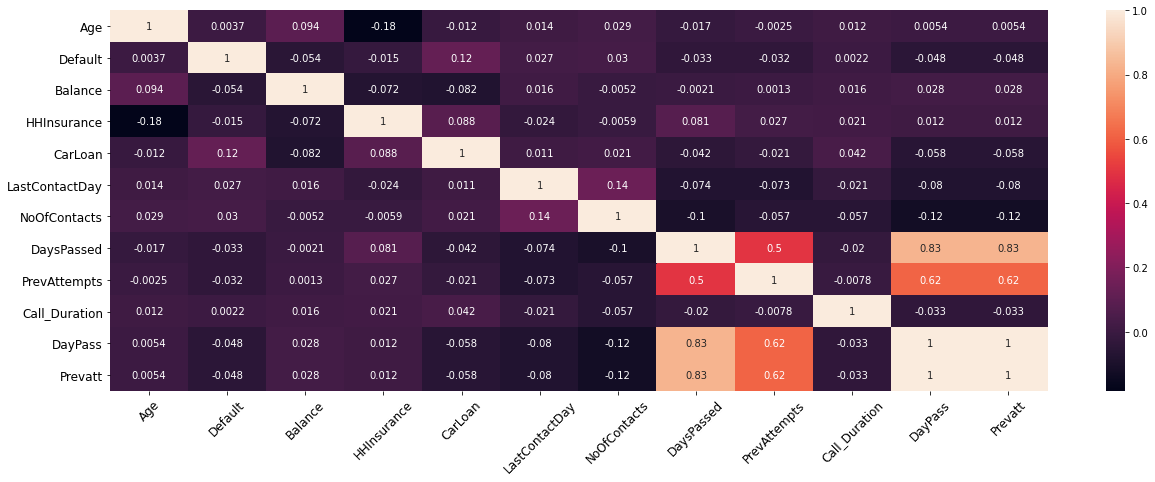

In [ ]:
plt.figure(figsize=(21,7))
res=sns.heatmap(data.drop(['CarInsurance','Id'],axis=1).corr(),annot=True)
res.set_xticklabels (res.get_xmajorticklabels (), fontsize = 12,rotation=45)
res.set_yticklabels (res.get_xmajorticklabels (), fontsize = 12)

In [ ]:
list(data.columns)

['Id',
 'Age',
 'Job',
 'Marital',
 'Education',
 'Default',
 'Balance',
 'HHInsurance',
 'CarLoan',
 'Communication',
 'LastContactDay',
 'LastContactMonth',
 'NoOfContacts',
 'DaysPassed',
 'PrevAttempts',
 'CallStart',
 'CallEnd',
 'CarInsurance',
 'Call_Duration',
 'Age Range',
 'Day_Categories',
 'NoOfContacts_Category',
 'DayPass',
 'Prevatt']

In [ ]:
data_new = pd.DataFrame(data)

- 분석 대상 변수를 다음과 같이 선정하였다.

In [ ]:
data_new.drop(['Id','CallStart','CallEnd','Age Range','DaysPassed','PrevAttempts','Day_Categories','NoOfContacts_Category'],axis=1,inplace=True)

In [ ]:
data_2 = pd.get_dummies(data=data_new,columns=['Job','Marital','Education','Communication','LastContactMonth'],drop_first=False)

In [ ]:
list(data_2.columns)

['Age',
 'Default',
 'Balance',
 'HHInsurance',
 'CarLoan',
 'LastContactDay',
 'NoOfContacts',
 'CarInsurance',
 'Call_Duration',
 'DayPass',
 'Prevatt',
 'Job_admin.',
 'Job_blue-collar',
 'Job_entrepreneur',
 'Job_housemaid',
 'Job_management',
 'Job_retired',
 'Job_self-employed',
 'Job_services',
 'Job_student',
 'Job_technician',
 'Job_unemployed',
 'Marital_divorced',
 'Marital_married',
 'Marital_single',
 'Education_primary',
 'Education_secondary',
 'Education_tertiary',
 'Communication_cellular',
 'Communication_telephone',
 'LastContactMonth_apr',
 'LastContactMonth_aug',
 'LastContactMonth_dec',
 'LastContactMonth_feb',
 'LastContactMonth_jan',
 'LastContactMonth_jul',
 'LastContactMonth_jun',
 'LastContactMonth_mar',
 'LastContactMonth_may',
 'LastContactMonth_nov',
 'LastContactMonth_oct',
 'LastContactMonth_sep']

In [ ]:
#데이터 스플릿

X = data_2.drop('CarInsurance',axis=1)
y = data_2['CarInsurance']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1217)

- 정규분포에 가까운 고른 분포를 가진 변수가 거의 없고, 한쪽으로 쏠린 데이터가 많아 형태 유지를 위해 MINMAX 사용.

In [ ]:
mm_scaler = MinMaxScaler()

Age_scaler = mm_scaler.fit(X_train['Age'].values.reshape(-1,1))
Balance_scaler = mm_scaler.fit(X_train['Balance'].values.reshape(-1,1))
Call_Duration_scaler = mm_scaler.fit(X_train['Call_Duration'].values.reshape(-1,1))
NoOfContacts_scaler = mm_scaler.fit(X_train['NoOfContacts'].values.reshape(-1,1))
LastContactDay_scaler = mm_scaler.fit(X_train['LastContactDay'].values.reshape(-1,1))

X_train['Age_scaled'] = Age_scaler.transform(X_train['Age'].values.reshape(-1,1))
X_train['Balance_scaled'] = Balance_scaler.transform(X_train['Balance'].values.reshape(-1,1))
X_train['Call_Duration_scaled'] = Call_Duration_scaler.transform(X_train['Call_Duration'].values.reshape(-1,1))
X_train['NoOfContacts_scaled'] = NoOfContacts_scaler.transform(X_train['NoOfContacts'].values.reshape(-1,1))
X_train['LastContactDay_scaled'] = LastContactDay_scaler.transform(X_train['LastContactDay'].values.reshape(-1,1))

#X_train.drop(['Age','Balance','Call_Duration','NoOfContacts','LastContactDay'],axis=1)

In [ ]:
# 0과 1의 비율이 5:5와 크게 다르지 않아 오버 샘플링이나 다운 샘플링은 pass
data.CarInsurance.mean()

0.401

In [ ]:
X_test['Age_scaled'] = Age_scaler.transform(X_test['Age'].values.reshape(-1,1))
X_test['Balance_scaled'] = Balance_scaler.transform(X_test['Balance'].values.reshape(-1,1))
X_test['Call_Duration_scaled'] = Call_Duration_scaler.transform(X_test['Call_Duration'].values.reshape(-1,1))
X_test['NoOfContacts_scaled'] = NoOfContacts_scaler.transform(X_test['NoOfContacts'].values.reshape(-1,1))
X_test['LastContactDay_scaled'] = LastContactDay_scaler.transform(X_test['LastContactDay'].values.reshape(-1,1))

#X_test.drop(['Age','Balance','Call_Duration','NoOfContacts','LastContactDay'],axis=1)

In [ ]:
df_X_train = X_train.drop(['Age','Balance','Call_Duration','NoOfContacts','LastContactDay'],axis=1)
df_X_test = X_test.drop(['Age','Balance','Call_Duration','NoOfContacts','LastContactDay'],axis=1)

## **2. 차원 축소**

### 2.1 Manifold

In [ ]:
# TSNE

from sklearn.manifold import TSNE
from pandas import DataFrame

# n_components(default=2) : Dimension of the embedded space

tsne = TSNE(random_state=42)
X_train_fit_tsne = tsne.fit(df_X_train)
X_train_tsne = X_train_fit_tsne.fit_transform(df_X_train)
X_test_tsne = X_train_fit_tsne.fit_transform(df_X_test)

#a={'TSNE_1':X_train_tsne[:,0], 
#   'TSNE_2':X_train_tsne[:,1], 
#   'TSNE_3':X_train_tsne[:,2],
#   'DepVar':y_train}

#b={'TSNE_1':X_test_tsne[:,0], 
#   'TSNE_2':X_test_tsne[:,1], 
#   'TSNE_3':X_test_tsne[:,2],
#   'DepVar':y_test}

#df_train_tsne = DataFrame(a)
#df_test_tsne = DataFrame(b)

In [ ]:
# LLE
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=4, n_neighbors=10, random_state=42)

X_reduced_lle = lle.fit_transform(X)

f={'LLE_1':X_reduced_lle[:,0], 
   'LLE_2':X_reduced_lle[:,1], 
   'LLE_3':X_reduced_lle[:,2], 
   'LLE_4':X_reduced_lle[:,3], 
   'DepVar':y}

df_lle=DataFrame(f)

### 2.2 PCA

In [ ]:
from sklearn.decomposition import PCA
from pandas import DataFrame

# n_components : Number of components to keep. if n_components is not set all components are kept
# n_components 값으로 0~1 사이의 실수를 입력하면 지정된 비율만큼의 분산이 유지되는 최소한의 주성분 개수를 자동으로 선택

pca = PCA()
X_train_fit_pca = pca.fit(df_X_train)
X_train_pca = X_train_fit_pca.transform(df_X_train)
X_test_pca = X_train_fit_pca.transform(df_X_test)

c={'PCA_1':X_train_pca[:,0],
   'PCA_2':X_train_pca[:,1],
   'PCA_3':X_train_pca[:,2],
#   'PCA_4':X_train_pca[:,3],
   'DepVar':y_train}

d={'PCA_1':X_test_pca[:,0],
   'PCA_2':X_test_pca[:,1],
   'PCA_3':X_test_pca[:,2],
#   'PCA_4':X_test_pca[:,3],
   'DepVar':y_test}


df_train_pca = DataFrame(c)
df_test_pca = DataFrame(d)

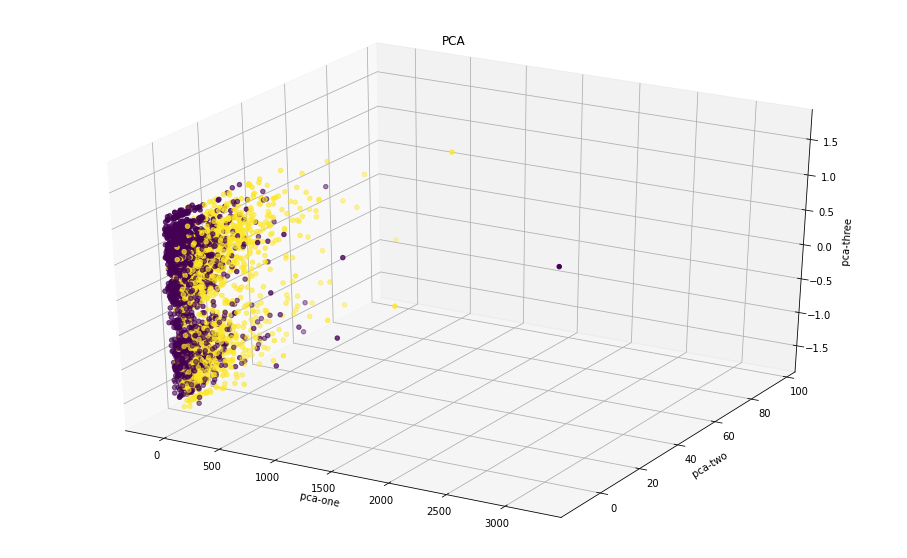

In [ ]:
ax = plt.figure (figsize = (16,10)). gca (projection = '3d') 
ax.scatter ( 
    xs = df_train_pca.loc [:, :] [ "PCA_1"], 
    ys = df_train_pca.loc [:, :] [ "PCA_2"], 
    zs = df_train_pca.loc [:, :] [ "PCA_3"], 
    c = df_train_pca.loc [:, :] [ "DepVar"], 
) 
ax.set_xlabel ('pca-one ') 
ax.set_ylabel ('pca-two ') 
ax.set_zlabel ('pca-three ') 
plt.title("PCA")
plt.show ()

In [ ]:
pca.explained_variance_ratio_

array([9.90540012e-01, 9.17948318e-03, 3.72438603e-05, 3.27996712e-05,
       2.63912750e-05, 2.40604995e-05, 1.64243889e-05, 1.31773371e-05,
       1.23175639e-05, 1.10274352e-05, 9.84435468e-06, 8.86144747e-06,
       8.36710227e-06, 8.03903075e-06, 7.14887748e-06, 6.87379515e-06,
       6.68792874e-06, 5.98128906e-06, 5.85845574e-06, 5.70340036e-06,
       5.33233891e-06, 3.92796560e-06, 3.41351703e-06, 2.74130599e-06,
       2.42774295e-06, 2.40463732e-06, 2.17463504e-06, 2.13370492e-06,
       1.89341309e-06, 1.68619364e-06, 1.66656287e-06, 1.43206186e-06,
       1.05465307e-06, 7.28301659e-07, 6.80567474e-07, 1.95349573e-31,
       9.85290576e-33, 9.85290576e-33, 9.85290576e-33, 9.85290576e-33,
       9.85290576e-33])

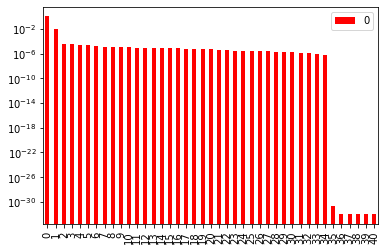

In [ ]:
PC_ratio = pca.explained_variance_ratio_
PC_ratio_df = pd.DataFrame(PC_ratio)
PC_ratio_df.plot(kind='bar', logy=True, color='r')

### 2.3 Kernel PCA

In [ ]:
# Kernel : linear fcn
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(kernel="linear", fit_inverse_transform=True)

X_train_fit_lin = lin_pca.fit(df_X_train)
X_train_lin = X_train_fit_lin.transform(df_X_train)
X_test_lin = X_train_fit_lin.transform(df_X_test)

#c={'lin_PCA_1':X_reduced_lin[:,0], 
#   'lin_PCA_2':X_reduced_lin[:,1], 
#   'lin_PCA_3':X_reduced_lin[:,2], 
#   'lin_PCA_4':X_reduced_lin[:,3],
#   'DepVar':y}

#df_lin=DataFrame(c)

In [ ]:
X_train_lin[0]

array([-5.00294738e+01, -5.79167681e+00,  3.86149933e-01, -3.68306140e-01,
       -2.59351862e-01, -8.05501798e-01, -5.69496134e-01, -3.86308673e-01,
       -7.53700114e-01,  5.85947979e-01,  4.47838091e-02, -3.89225176e-01,
        1.73273313e-01,  2.23851309e-01,  8.33220438e-02, -7.32296759e-02,
       -1.80518275e-01,  1.68365462e-01, -1.15519879e-01,  1.54632560e-01,
        1.21394361e-01,  6.34853936e-02,  8.58399092e-02, -1.09782514e-01,
       -6.51078138e-02,  4.95534710e-03, -3.79778537e-02, -2.73540657e-03,
       -9.85303337e-02,  9.96109073e-03,  2.85401234e-02,  1.67844582e-02,
       -1.45087369e-02, -1.67873216e-03, -8.25318882e-02])

In [ ]:
# Kernel : rbf fcn
rbf_pca = KernelPCA(kernel="rbf", fit_inverse_transform=True)

X_train_fit_rbf = rbf_pca.fit(df_X_train)
X_train_rbf = X_train_fit_rbf.transform(df_X_train)
X_test_rbf = X_train_fit_rbf.transform(df_X_test)

#e={'rbf_PCA_1':X_train_rbf[:,0], 
#   'rbf_PCA_2':X_train_rbf[:,1], 
#   'rbf_PCA_3':X_train_rbf[:,2], 
#   'rbf_PCA_4':X_train_rbf[:,3],
#   'DepVar':y_train}

#f={'rbf_PCA_1':X_test_rbf[:,0], 
#   'rbf_PCA_2':X_test_rbf[:,1], 
#   'rbf_PCA_3':X_test_rbf[:,2], 
#   'rbf_PCA_4':X_test_rbf[:,3],
#   'DepVar':y_test}


#df_train_rbf = DataFrame(e)
#df_test_rbf = DataFrame(f)

In [ ]:
len(list(X_train_rbf[0]))

3199

### 2.4 SelectKBoost

In [ ]:
Best_Params=SelectKBest(score_func=f_classif, k=10)
X_train_fit_skb = Best_Params.fit(df_X_train,y_train)

df_scores = pd.DataFrame(Best_Params.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_score_evaluation = pd.concat([df_scores,df_columns],axis=1)
df_score_evaluation.columns = ['Scores','Features']

print(df_score_evaluation.nlargest(10,'Scores'))

X_train_skb = X_train_fit_skb.transform(df_X_train)
X_test_skb = X_train_fit_skb.transform(df_X_test)

df_train_skb = pd.DataFrame([X_train_skb,y_train])
df_test_skb = pd.DataFrame([X_test_skb,y_test])

        Scores              Features
38  958.846764  LastContactMonth_nov
1   144.266378               Default
3   130.341181           HHInsurance
4   130.341181               CarLoan
32   80.448464  LastContactMonth_feb
35   60.144076  LastContactMonth_jun
34   56.173147  LastContactMonth_jul
6    45.596982          NoOfContacts
39   39.123677  LastContactMonth_oct
31   38.205888  LastContactMonth_dec


/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


### 2.5 T-SNE

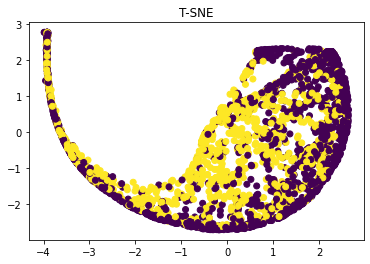

In [ ]:
# Perform the necessary imports
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 50, random_state=0,n_iter=250)
tsne_results = tsne.fit_transform(df_X_train)
tsne_results=pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
plt.scatter(tsne_results['tsne1'], tsne_results['tsne2'], c=y_train)
plt.title("T-SNE")
plt.show()


## 3. Modelling

<모델링 결과>
- Raw-XGBoost의 경우 85.28%로 정확도가 가장 높다. 
- 정밀도는 80.36%, 재현율은 83.65%이다.
- XGBoost의 경우 차원축소를 실시하였을 때 정확도가 낮아진다. T-SNE와 PCA_variance-ratio를 고려해보았을 때, 데이터 전체를 설명할 수 있는 몇 가지 소수의 축이 존재하기보다는 각 feature가 고른 설명력을 가지기 때문임을 유추할 수 있다. 

<예상 피드백>
- kernel-rbf 했을 때만 정확도가 많이 낮아진다. 왜?
- 몇 가지 모델 하이퍼파라미터 재조정 필요해보임
- 데이터 전처리 범주화 기준 좀 더 명확히

In [ ]:
# train test split(앞에서 함)
X_tsne = df_tsne.drop(['DepVar'], axis=1)
y_tsne = df_tsne['DepVar']
X_lle = df_tsne.drop(['DepVar'], axis=1)
y_lle = df_tsne['DepVar']
X_pca = df_pca.drop(['DepVar'], axis=1)
y_pca = df_pca['DepVar']
X_lin = df_lin.drop(['DepVar'], axis=1)
y_lin = df_lin['DepVar']
X_rbf = df_rbf.drop(['DepVar'], axis=1)
y_rbf = df_rbf['DepVar']
X_sig = df_sig.drop(['DepVar'], axis=1)
y_sig = df_sig['DepVar']
X_skb = X[['Call_Duration', 'HHInsurance', 'LastContactMonth_may', 'PrevAttempts', 'Age Range_61-70', 'DaysPassed', 'LastContactMonth_sep', 'LastContactMonth_oct', 'LastContactMonth_oct', 'LastContactMonth_mar', 'NoOfContacts']]
y_skb = y

from sklearn.model_selection import train_test_split

X_tsne_train, X_tsne_test = train_test_split(X_tsne, test_size=0.2, random_state=156)
y_tsne_train, y_tsne_test = train_test_split(y_tsne, test_size=0.2, random_state=156)
X_lle_train, X_lle_test = train_test_split(X_lle, test_size=0.2, random_state=156)
y_lle_train, y_lle_test = train_test_split(y_lle, test_size=0.2, random_state=156)
X_pca_train, X_pca_test = train_test_split(X_pca, test_size=0.2, random_state=156)
y_pca_train, y_pca_test = train_test_split(y_pca, test_size=0.2, random_state=156)
X_lin_train, X_lin_test = train_test_split(X_lin, test_size=0.2, random_state=156)
y_lin_train, y_lin_test = train_test_split(y_lin, test_size=0.2, random_state=156)
X_rbf_train, X_rbf_test = train_test_split(X_rbf, test_size=0.2, random_state=156)
y_rbf_train, y_rbf_test = train_test_split(y_rbf, test_size=0.2, random_state=156)
X_sig_train, X_sig_test = train_test_split(X_sig, test_size=0.2, random_state=156)
y_sig_train, y_sig_test = train_test_split(y_sig, test_size=0.2, random_state=156)
X_skb_train, X_skb_test = train_test_split(X_skb, test_size=0.2, random_state=156)
y_skb_train, y_skb_test = train_test_split(y_skb, test_size=0.2, random_state=156)

**3-1. Logistic Regression**

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(df_X_train,y_train)

results.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=1.0,solver='newton-cg')

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8225
정밀도: 0.7876
재현율: 0.7579
F1: 0.7724
AUC: 0.8115


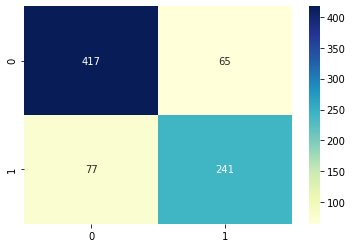

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(X_train_pca,y_train)

results.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=1.0,solver='liblinear')

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8225
정밀도: 0.7876
재현율: 0.7579
F1: 0.7724
AUC: 0.8115


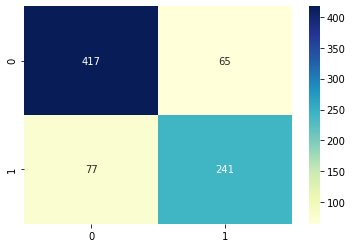

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(X_train_lin,y_train)

results.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=1.0,solver='newton-cg')

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8225
정밀도: 0.7876
재현율: 0.7579
F1: 0.7724
AUC: 0.8115


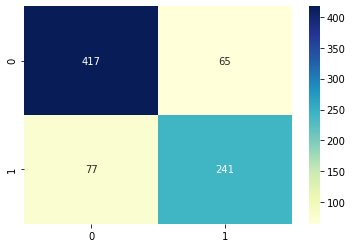

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(X_train_tsne,y_train)

results.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=0.01,solver='liblinear')

themodel.fit(X_train_tsne,y_train)

y_predict=themodel.predict(X_test_tsne)

[[482   0]
 [318   0]]


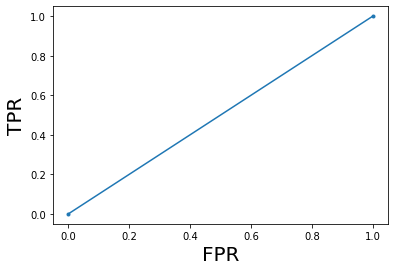

In [ ]:
print(confusion_matrix(y_test,y_predict))

#plt.figure(figsize=(12,6))
#plt.plot([0, 1], [0, 1], label='straight_line'') 

fpr, tpr, _ = roc_curve(y_test,y_predict)
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')

auc = roc_auc_score(y_test, y_predict)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)

plt.show()

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(X_train_rbf,y_train)

results.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=10,solver='liblinear')

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.7812
정밀도: 0.7241
재현율: 0.7264
F1: 0.7253
AUC: 0.7719


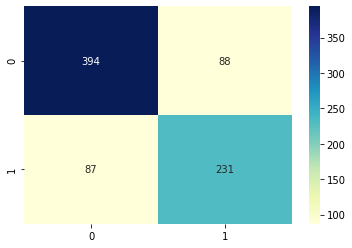

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
para = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=para)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=cv, 
                           scoring='accuracy',
                           error_score=0)

results=grid_search.fit(X_train_skb, y_train)

results.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
themodel = LogisticRegression(penalty='l2',C=1.0,solver='liblinear')

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.8137
정밀도: 0.7884
재현율: 0.7264
F1: 0.7561
AUC: 0.7989


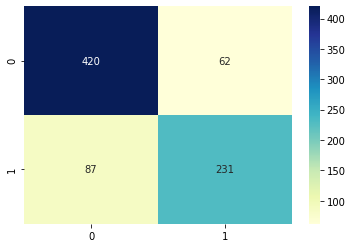

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

**3-2.SVC**

In [ ]:
svc_model=SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

svc_grid = dict(kernel=kernel,C=C,gamma=gamma)

svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_grid, n_jobs=-1, cv=svc_cv, scoring='accuracy',error_score=0)

svc_grid_result=svc_grid_search.fit(X_train_pca,y_train)

svc_grid_result.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
themodel = SVC(kernel='rbf',C=50,gamma='scale')

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8137
정밀도: 0.7826
재현율: 0.7358
F1: 0.7585
AUC: 0.8005


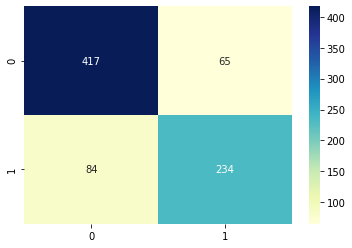

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
svc_model=SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

svc_grid = dict(kernel=kernel,C=C,gamma=gamma)

svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_grid, n_jobs=-1, cv=svc_cv, scoring='accuracy',error_score=0)

svc_grid_result=svc_grid_search.fit(df_X_train,y_train)

svc_grid_result.best_params_

In [ ]:
themodel = SVC(kernel='rbf',C=50,gamma='scale')

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8100
정밀도: 0.7785
재현율: 0.7296
F1: 0.7532
AUC: 0.7963


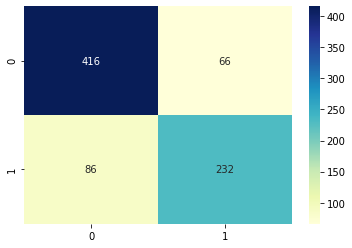

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
svc_model=SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

svc_grid = dict(kernel=kernel,C=C,gamma=gamma)

svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_grid, n_jobs=-1, cv=svc_cv, scoring='accuracy',error_score=0)

svc_grid_result=svc_grid_search.fit(X_train_lin,y_train)

svc_grid_result.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
themodel = SVC(kernel='rbf',C=50,gamma='scale')

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8137
정밀도: 0.7826
재현율: 0.7358
F1: 0.7585
AUC: 0.8005


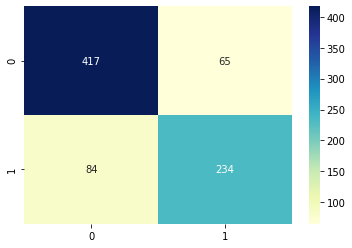

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
svc_model=SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

svc_grid = dict(kernel=kernel,C=C,gamma=gamma)

svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_grid, n_jobs=-1, cv=svc_cv, scoring='accuracy',error_score=0)

svc_grid_result=svc_grid_search.fit(X_train_rbf,y_train)

svc_grid_result.best_params_

In [ ]:
themodel = SVC(kernel='rbf',C=1.0,gamma='scale')

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.7712
정밀도: 0.7170
재현율: 0.7013
F1: 0.7091
AUC: 0.7593


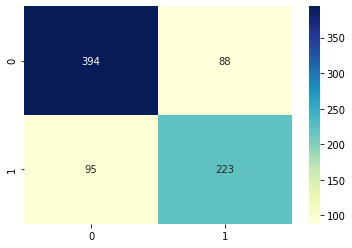

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
svc_model=SVC()

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']

svc_grid = dict(kernel=kernel,C=C,gamma=gamma)

svc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

svc_grid_search = GridSearchCV(estimator=svc_model, param_grid=svc_grid, n_jobs=-1, cv=svc_cv, scoring='accuracy',error_score=0)

svc_grid_result=svc_grid_search.fit(X_train_skb,y_train)

svc_grid_result.best_params_

In [ ]:
themodel = SVC(kernel='rbf',C=50,gamma='scale')

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.8175
정밀도: 0.7704
재현율: 0.7704
F1: 0.7704
AUC: 0.8095


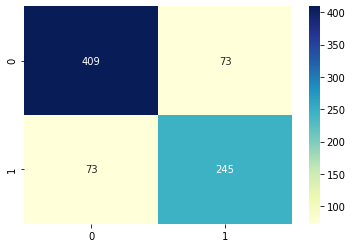

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

3-3. Bagging

In [ ]:
themodel = BaggingClassifier(n_estimators = 1000)

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8363
정밀도: 0.7825
재현율: 0.8145
F1: 0.7982
AUC: 0.8325


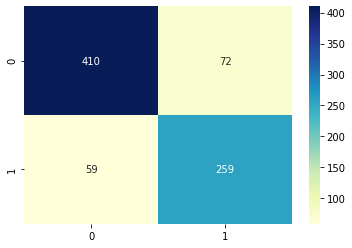

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = BaggingClassifier(n_estimators = 1000)

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8313
정밀도: 0.7748
재현율: 0.8113
F1: 0.7926
AUC: 0.8279


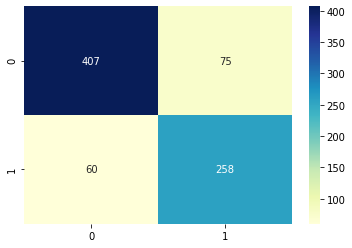

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = BaggingClassifier(n_estimators = 1000)

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8275
정밀도: 0.7695
재현율: 0.8082
F1: 0.7883
AUC: 0.8242


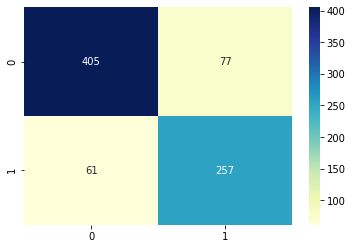

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = BaggingClassifier(n_estimators = 100)

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.7163
정밀도: 0.7382
재현율: 0.4434
F1: 0.5540
AUC: 0.6698


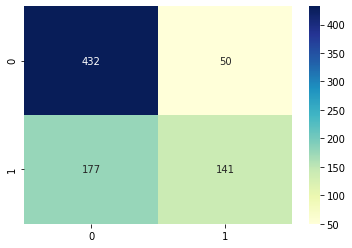

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = BaggingClassifier(n_estimators = 1000)

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.7638
정밀도: 0.6925
재현율: 0.7296
F1: 0.7106
AUC: 0.7579


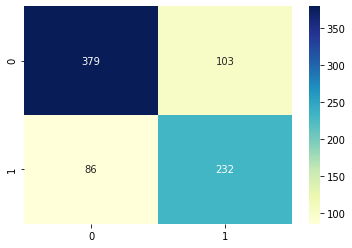

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

3-4. RidgeRegression

In [ ]:
ridge_model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ridge_grid = dict(alpha=alpha)

ridge_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_grid, n_jobs=-1, cv=ridge_cv, scoring='accuracy',error_score=0)

ridge_grid_result=ridge_grid_search.fit(X_train_skb,y_train)

ridge_grid_result.best_params_

{'alpha': 1.0}

In [ ]:
themodel = RidgeClassifier(alpha= 1.0)

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.8050
정밀도: 0.8092
재현율: 0.6667
F1: 0.7310
AUC: 0.7815


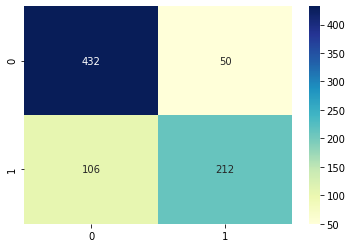

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
ridge_model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ridge_grid = dict(alpha=alpha)

ridge_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_grid, n_jobs=-1, cv=ridge_cv, scoring='accuracy',error_score=0)

ridge_grid_result=ridge_grid_search.fit(X_train_pca,y_train)

ridge_grid_result.best_params_

{'alpha': 0.8}

In [ ]:
themodel = RidgeClassifier(alpha= 0.8)

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8175
정밀도: 0.8116
재현율: 0.7044
F1: 0.7542
AUC: 0.7983


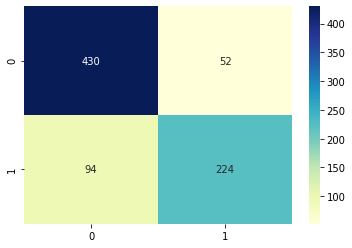

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
ridge_model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ridge_grid = dict(alpha=alpha)

ridge_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_grid, n_jobs=-1, cv=ridge_cv, scoring='accuracy',error_score=0)

ridge_grid_result=ridge_grid_search.fit(df_X_train,y_train)

ridge_grid_result.best_params_

{'alpha': 0.8}

In [ ]:
themodel = RidgeClassifier(alpha= 0.8)

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8175
정밀도: 0.8116
재현율: 0.7044
F1: 0.7542
AUC: 0.7983


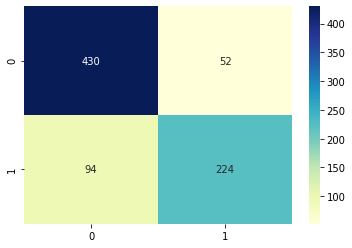

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
ridge_model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ridge_grid = dict(alpha=alpha)

ridge_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_grid, n_jobs=-1, cv=ridge_cv, scoring='accuracy',error_score=0)

ridge_grid_result=ridge_grid_search.fit(X_train_rbf,y_train)

ridge_grid_result.best_params_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'alpha': 0.5}

In [ ]:
themodel = RidgeClassifier(alpha= 0.5)

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.7825
정밀도: 0.7250
재현율: 0.7296
F1: 0.7273
AUC: 0.7735


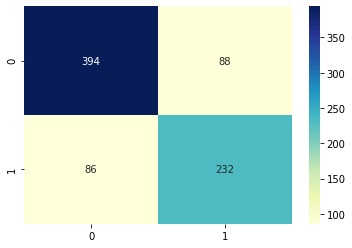

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
ridge_model = RidgeClassifier()

alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

ridge_grid = dict(alpha=alpha)

ridge_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ridge_grid_search = GridSearchCV(estimator=ridge_model, param_grid=ridge_grid, n_jobs=-1, cv=ridge_cv, scoring='accuracy',error_score=0)

ridge_grid_result=ridge_grid_search.fit(X_train_lin,y_train)

ridge_grid_result.best_params_

{'alpha': 0.8}

In [ ]:
themodel = RidgeClassifier(alpha= 0.8)

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8175
정밀도: 0.8116
재현율: 0.7044
F1: 0.7542
AUC: 0.7983


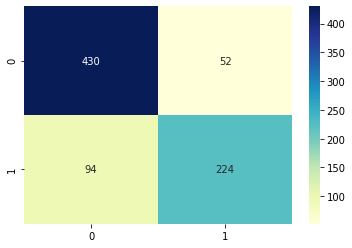

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

3-5.RandomForest

In [ ]:
rfc_model = RandomForestClassifier()

max_features = ['sqrt', 'log2']

rfc_n_estimators = [50]

rfc_grid = dict(n_estimators=rfc_n_estimators,max_features=max_features)

rfc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfc_grid_search = GridSearchCV(estimator=rfc_model, param_grid=rfc_grid, n_jobs=-1, cv=rfc_cv, scoring='accuracy',error_score=0)

rfc_grid_result=rfc_grid_search.fit(df_X_train,y_train)

rfc_grid_result.best_params_

{'max_features': 'sqrt', 'n_estimators': 50}

In [ ]:
themodel = RandomForestClassifier(n_estimators = 50,max_features = 'sqrt')

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8287
정밀도: 0.7873
재현율: 0.7799
F1: 0.7836
AUC: 0.8204


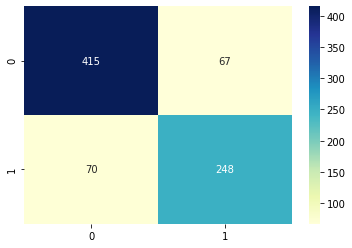

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
rfc_model = RandomForestClassifier()

max_features = ['sqrt', 'log2']

rfc_n_estimators = [50]

rfc_grid = dict(n_estimators=rfc_n_estimators,max_features=max_features)

rfc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfc_grid_search = GridSearchCV(estimator=rfc_model, param_grid=rfc_grid, n_jobs=-1, cv=rfc_cv, scoring='accuracy',error_score=0)

rfc_grid_result=rfc_grid_search.fit(X_train_pca,y_train)

rfc_grid_result.best_params_

{'max_features': 'sqrt', 'n_estimators': 50}

In [ ]:
themodel = RandomForestClassifier(n_estimators = 50,max_features = 'sqrt')

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8275
정밀도: 0.7727
재현율: 0.8019
F1: 0.7870
AUC: 0.8231


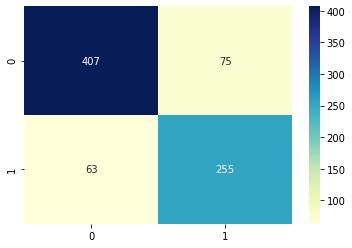

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
rfc_model = RandomForestClassifier()

max_features = ['sqrt', 'log2']

rfc_n_estimators = [50]

rfc_grid = dict(n_estimators=rfc_n_estimators,max_features=max_features)

rfc_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfc_grid_search = GridSearchCV(estimator=rfc_model, param_grid=rfc_grid, n_jobs=-1, cv=rfc_cv, scoring='accuracy',error_score=0)

rfc_grid_result=rfc_grid_search.fit(X_train_lin,y_train)

rfc_grid_result.best_params_

{'max_features': 'sqrt', 'n_estimators': 50}

In [ ]:
themodel = RandomForestClassifier(n_estimators = 50,max_features = 'sqrt')

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8300
정밀도: 0.7826
재현율: 0.7925
F1: 0.7875
AUC: 0.8236


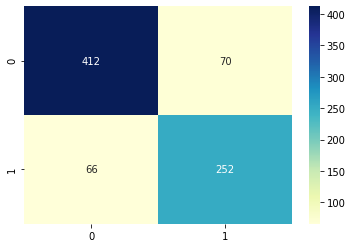

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = RandomForestClassifier(n_estimators = 50,max_features = 'sqrt')

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.6587
정밀도: 0.7473
재현율: 0.2138
F1: 0.3325
AUC: 0.5831


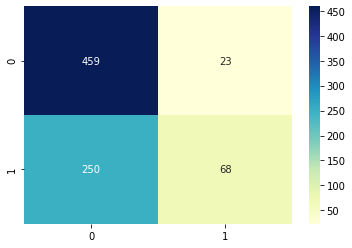

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = RandomForestClassifier(n_estimators = 50,max_features = 'sqrt')

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.7738
정밀도: 0.7082
재현율: 0.7327
F1: 0.7202
AUC: 0.7668


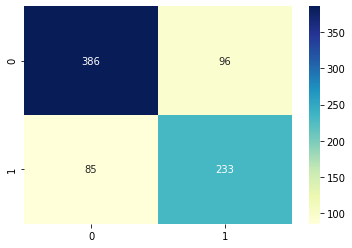

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

3-6.Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

themodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.5)

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)


정확도: 0.8137
정밀도: 0.7700
재현율: 0.7579
F1: 0.7639
AUC: 0.8042


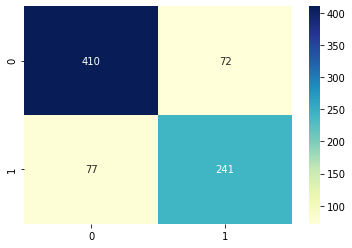

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1)

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8200
정밀도: 0.7702
재현율: 0.7799
F1: 0.7750
AUC: 0.8132


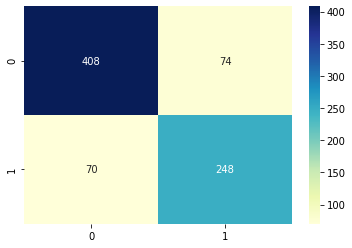

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.5)

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.6837
정밀도: 0.6720
재현율: 0.3994
F1: 0.5010
AUC: 0.6354


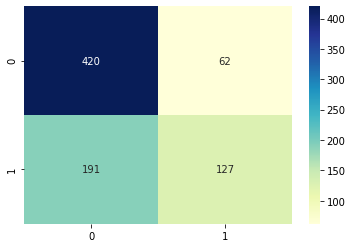

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=0.5)

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.8237
정밀도: 0.8000
재현율: 0.7421
F1: 0.7700
AUC: 0.8099


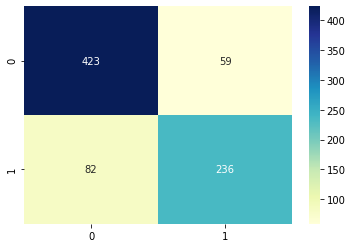

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1)

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8200
정밀도: 0.7702
재현율: 0.7799
F1: 0.7750
AUC: 0.8132


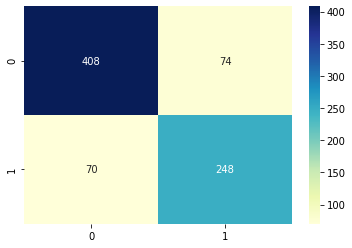

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

3-7.XGBoost

In [ ]:
import xgboost
from xgboost import XGBClassifier

xgb_clf = xgboost.XGBClassifier()

param_grid = {'booster':['gbtree'], 
              'max_depth':[5,6,8],
              'n_estimators':[50, 100, 150]}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=cv, 
                           scoring='accuracy', 
                           error_score=0)

results=grid_search.fit(df_X_train, y_train)

results.best_params_

{'booster': 'gbtree', 'max_depth': 5, 'n_estimators': 150}

In [ ]:
import xgboost
from xgboost import XGBClassifier

themodel = xgboost.XGBClassifier(booster='gbtree', max_depth=5, n_estimators=150)

themodel.fit(df_X_train,y_train)

y_predict=themodel.predict(df_X_test)

In [ ]:
y_predict_prob = themodel.predict_proba(df_X_test)

In [ ]:
#Threshold 값에 따른 Recall 값 도출 함수

def judge_by_thres(thres):

  judges = []
  for k in range(len(list(y_predict_prob))):
    if float(y_predict_prob[k][1]) >= thres :
      judges.append(1)
    else :
      judges.append(0)
  
  return recall_score(y_test, np.array(judges))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


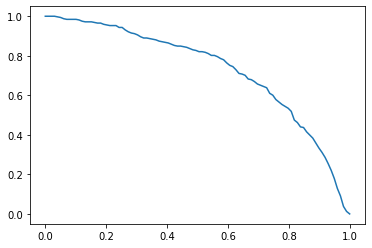

In [ ]:
#XGBoost-Raw에서 Threshold 변화에 따른 recall의 변화

recalls = []

for n in list(np.linspace(0,1,num=100)):
  a = judge_by_thres(n)
  recalls.append(a)

x = list(np.linspace(0,1,num=100))
y = recalls
sns.lineplot(x,y)


정확도: 0.8500
정밀도: 0.8018
재현율: 0.8270
F1: 0.8142
AUC: 0.8461


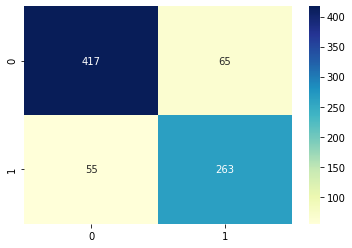

In [ ]:
#Threshold = 0.5 일 때의 Model Valuation

from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

def get_clf_eval(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    F1 = f1_score(y_test, y_predict)
    AUC = roc_auc_score(y_test, y_predict)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

    sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt='d',cmap='YlGnBu')

get_clf_eval(y_test, y_predict)

In [ ]:
themodel.feature_importances_

array([0.01945173, 0.15097664, 0.02749413, 0.01947639, 0.03391337,
       0.03443757, 0.0137018 , 0.01697399, 0.01762729, 0.01535343,
       0.01710319, 0.01690864, 0.01694218, 0.01416901, 0.01522908,
       0.01725802, 0.01782569, 0.01656431, 0.01928338, 0.02031473,
       0.01736503, 0.02369977, 0.02106553, 0.01211809, 0.02403606,
       0.01738098, 0.01457167, 0.01901363, 0.01554792, 0.02068715,
       0.01958057, 0.01840567, 0.02500798, 0.09502579, 0.01922924,
       0.02052953, 0.01625288, 0.01426073, 0.01897179, 0.01732988,
       0.0289155 ], dtype=float32)

In [ ]:
x = list(df_X_train.columns)
y = list(themodel.feature_importances_)
df_imp = pd.DataFrame(y, index=x)
df_imp.sort_values(by=[0],axis=0,ascending=False)

,0
HHInsurance,0.150977
LastContactMonth_nov,0.095026
Job_admin.,0.034438
Prevatt,0.033913
LastContactDay_scaled,0.028915
CarLoan,0.027494
LastContactMonth_may,0.025008
LastContactMonth_apr,0.024036
Education_tertiary,0.023700
Communication_cellular,0.021066


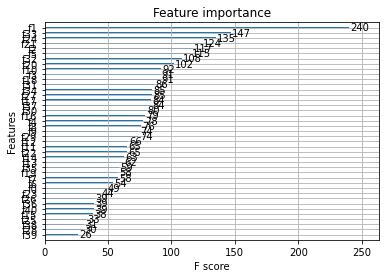

In [ ]:
from xgboost import plot_importance
plot_importance(themodel)
plt.show()

In [ ]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'booster':['gbtree'], 
              'max_depth':[5,6,8],
              'n_estimators':[50, 100, 150]}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=cv, 
                           scoring='accuracy', 
                           error_score=0)

results=grid_search.fit(X_train_pca, y_train)

results.best_params_

{'booster': 'gbtree', 'max_depth': 6, 'n_estimators': 100}

In [ ]:
themodel = xgboost.XGBClassifier(booster='gbtree', max_depth=6, n_estimators=100)

themodel.fit(X_train_pca,y_train)

y_predict=themodel.predict(X_test_pca)


정확도: 0.8400
정밀도: 0.7844
재현율: 0.8239
F1: 0.8037
AUC: 0.8373


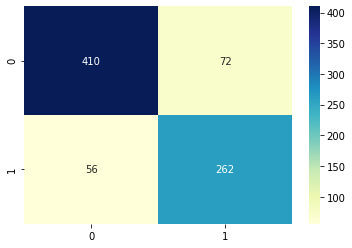

In [ ]:
get_clf_eval(y_test, y_predict)

In [ ]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'booster':['gbtree'], 
              'max_depth':[5,6,8],
              'n_estimators':[50, 100, 150]}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=cv, 
                           scoring='accuracy', 
                           error_score=0)

results=grid_search.fit(X_train_lin, y_train)

results.best_params_

{'booster': 'gbtree', 'max_depth': 5, 'n_estimators': 100}

In [ ]:
themodel = xgboost.XGBClassifier(booster='gbtree', max_depth=5, n_estimators=100)

themodel.fit(X_train_lin,y_train)

y_predict=themodel.predict(X_test_lin)


정확도: 0.8387
정밀도: 0.7872
재현율: 0.8145
F1: 0.8006
AUC: 0.8346


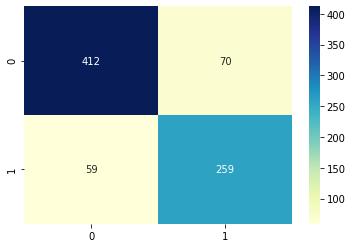

In [ ]:
get_clf_eval(y_test, y_predict)

In [ ]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'booster':['gbtree'], 
              'max_depth':[5,6,8],
              'n_estimators':[50, 100, 150]}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=cv, 
                           scoring='accuracy', 
                           error_score=0)

results=grid_search.fit(X_train_rbf, y_train)

results.best_params_

In [ ]:
themodel = xgboost.XGBClassifier(booster='gbtree', max_depth=6, n_estimators=50)

themodel.fit(X_train_rbf,y_train)

y_predict=themodel.predict(X_test_rbf)


정확도: 0.7050
정밀도: 0.7412
재현율: 0.3962
F1: 0.5164
AUC: 0.6525


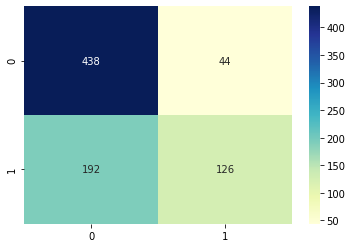

In [ ]:
get_clf_eval(y_test, y_predict)

In [ ]:
xgb_clf = xgboost.XGBClassifier()

param_grid = {'booster':['gbtree'], 
              'max_depth':[5,6,8],
              'n_estimators':[50, 100, 150]}

cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=xgb_clf, 
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=cv, 
                           scoring='accuracy', 
                           error_score=0)

results=grid_search.fit(X_train_skb, y_train)

results.best_params_

{'booster': 'gbtree', 'max_depth': 5, 'n_estimators': 50}

In [ ]:
themodel = xgboost.XGBClassifier(booster='gbtree', max_depth=5, n_estimators=50)

themodel.fit(X_train_skb,y_train)

y_predict=themodel.predict(X_test_skb)


정확도: 0.8175
정밀도: 0.7622
재현율: 0.7862
F1: 0.7740
AUC: 0.8122


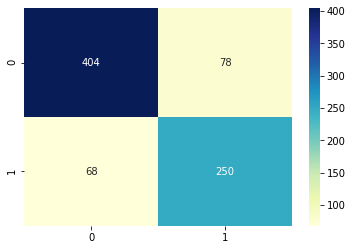

In [ ]:
get_clf_eval(y_test, y_predict)

3-8.LGBM

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



정확도: 0.6025
정밀도: 0.0000
재현율: 0.0000
F1: 0.0000
AUC: 0.5000


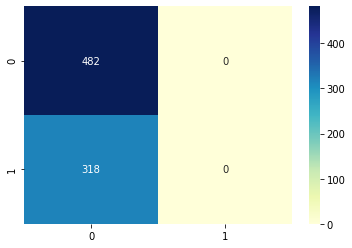

In [ ]:
import lightgbm as lgb

lgbm_clf = lgb.LGBMClassifier(boosting_type = 'gbdt',
                          colsample_bytree= 0.64,
                          learning_rate= 0.005,
                          max_bin= 255,
                          n_estimators= 8,
                          num_leaves= 6,
                          objective= 'binary',
                          random_state= 500,
                          reg_alpha= 1,
                          reg_lambda= 1,
                          subsample= 0.7)

lgbm_clf.fit(df_X_train,y_train)

y_predict=lgbm_clf.predict(df_X_test)

get_clf_eval(y_test, y_predict)

In [ ]:
themodel = lgb.LGBMClassifier()

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(estimator = themodel, param_grid = gridParams, verbose=1, cv=3, n_jobs=-1,scoring='accuracy',error_score=0)

grid.fit(X_train_pca, y_train)

print(grid.best_params_)

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 722 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 1722 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3122 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4922 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 7122 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 9722 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 10368 out of 10368 | elapsed:  9.5min finished


{'boosting_type': 'dart', 'colsample_bytree': 0.65, 'learning_rate': 0.01, 'max_bin': 510, 'n_estimators': 24, 'num_leaves': 16, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}



정확도: 0.6212
정밀도: 0.9412
재현율: 0.0503
F1: 0.0955
AUC: 0.5241


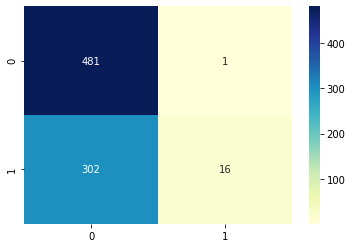

In [ ]:
lgbm_clf = lgb.LGBMClassifier(boosting_type = 'dart',
                          colsample_bytree= 0.65,
                          learning_rate= 0.01,
                          max_bin= 510,
                          n_estimators= 24,
                          num_leaves= 16,
                          objective= 'binary',
                          random_state= 500,
                          reg_alpha= 1,
                          reg_lambda= 1,
                          subsample= 0.7)

lgbm_clf.fit(X_train_pca,y_train)

y_predict=lgbm_clf.predict(X_test_pca)

get_clf_eval(y_test, y_predict)

3-9. GaussianNB

In [ ]:
gnb_model=GaussianNB()

gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gnb_grid_search = GridSearchCV(estimator=gnb_model, param_grid=gnb_grid, n_jobs=-1, cv=gnb_cv, scoring='accuracy',error_score=0)

gnb_grid_result=gnb_grid_search.fit(df_X_train,y_train)

gnb_grid_result.best_params_

{'var_smoothing': 4.328761281083053e-06}

In [ ]:
y_predict = gnb_grid_result.predict(df_X_test)


정확도: 0.8037
정밀도: 0.8084
재현율: 0.6635
F1: 0.7288
AUC: 0.7799


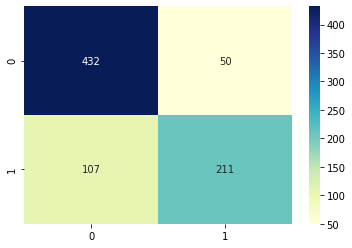

In [ ]:
get_clf_eval(y_test, y_predict)

In [ ]:
gnb_model=GaussianNB()

gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gnb_grid_search = GridSearchCV(estimator=gnb_model, param_grid=gnb_grid, n_jobs=-1, cv=gnb_cv, scoring='accuracy',error_score=0)

gnb_grid_result=gnb_grid_search.fit(X_train_pca,y_train)

gnb_grid_result.best_params_

{'var_smoothing': 2.848035868435799e-06}


정확도: 0.7800
정밀도: 0.8287
재현율: 0.5629
F1: 0.6704
AUC: 0.7431


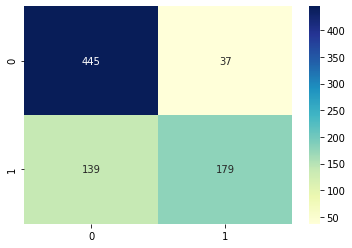

In [ ]:
y_predict = gnb_grid_result.predict(X_test_pca)

get_clf_eval(y_test, y_predict)

In [ ]:
gnb_model=GaussianNB()

gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gnb_grid_search = GridSearchCV(estimator=gnb_model, param_grid=gnb_grid, n_jobs=-1, cv=gnb_cv, scoring='accuracy',error_score=0)

gnb_grid_result=gnb_grid_search.fit(X_train_lin,y_train)

gnb_grid_result.best_params_

{'var_smoothing': 2.848035868435799e-06}


정확도: 0.7800
정밀도: 0.8287
재현율: 0.5629
F1: 0.6704
AUC: 0.7431


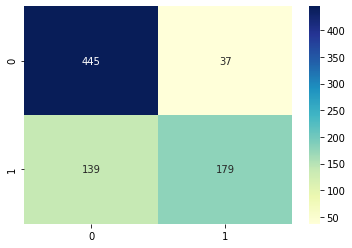

In [ ]:
y_predict = gnb_grid_result.predict(X_test_lin)

get_clf_eval(y_test, y_predict)

In [ ]:
gnb_model=GaussianNB()

gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gnb_grid_search = GridSearchCV(estimator=gnb_model, param_grid=gnb_grid, n_jobs=-1, cv=gnb_cv, scoring='accuracy',error_score=0)

gnb_grid_result=gnb_grid_search.fit(X_train_rbf,y_train)

gnb_grid_result.best_params_

{'var_smoothing': 0.0005336699231206307}


정확도: 0.6475
정밀도: 0.8000
재현율: 0.1509
F1: 0.2540
AUC: 0.5630


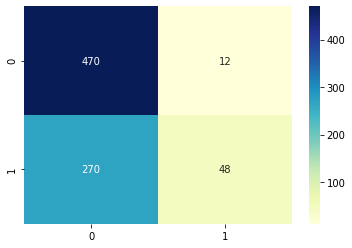

In [ ]:
y_predict = gnb_grid_result.predict(X_test_rbf)

get_clf_eval(y_test, y_predict)

In [ ]:
gnb_model=GaussianNB()

gnb_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

gnb_grid_search = GridSearchCV(estimator=gnb_model, param_grid=gnb_grid, n_jobs=-1, cv=gnb_cv, scoring='accuracy',error_score=0)

gnb_grid_result=gnb_grid_search.fit(X_train_skb,y_train)

gnb_grid_result.best_params_

{'var_smoothing': 0.0004328761281083057}


정확도: 0.7925
정밀도: 0.8276
재현율: 0.6038
F1: 0.6982
AUC: 0.7604


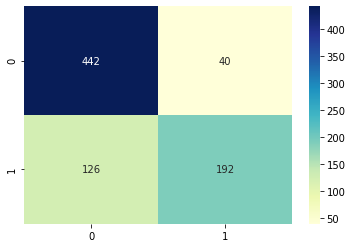

In [ ]:
y_predict = gnb_grid_result.predict(X_test_skb)

get_clf_eval(y_test, y_predict)

In [ ]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(df_X_train, y_train)
    print(name + " trained.")

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
   Support Vector Machine (RBF Kernel) trained.
                         Random Forest trained.
                     Gradient Boosting trained.


In [ ]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(df_X_test, y_test) * 100))

                   Logistic Regression: 82.50%
                   K-Nearest Neighbors: 63.00%
                         Decision Tree: 76.62%
   Support Vector Machine (RBF Kernel): 60.12%
                         Random Forest: 84.12%
                     Gradient Boosting: 84.88%


In [ ]:
plot_importabce()